In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)

# <center>Computational Mathematics Report</center>
### <center>Donato Meoli</center>
##### <center>d.meoli@studenti.unipi.it</center>

<center>Computational Mathematics course 646AA</center>
<center>Academic year: 2019/2020</center>

<center>Type of project: Wildcard #5 with Machine Learning</center>
<center>Group #35</center>

## Track

(M1) is a SVC with *hinge* and *squared hinge* losses; *linear*, *polynomial* and *gaussian* kernels.

(A1.1) is the *AdaGrad* algorithm [[1]](#ref-1), a *deflected subgradient method* for solving the SVC in its *primal* formulation with the non-differentiable *hinge* loss and a standard gradient descent algorithm for the *squared hinge* loss.

(A1.2) is the *Sequential Minimal Optimization* (SMO) algorithm [[2]](#ref-2) (see [[3]](#ref-3) for improvements), an ad-hoc *active set* method for training a SVM in its *Wolfe dual* formulation.

(A1.3) is the *AdaGrad* algorithm [[1]](#ref-1), a *deflected subgradient method* for solving the SVC in its *Lagrangian dual* formulation.

(M2) is a SVR with *epsilon-insensitive* and *squared epsilon-insensitive* losses; *linear*, *polynomial* and *gaussian* kernels.

(A2.1) is the *AdaGrad* algorithm [[1]](#ref-1), a *deflected subgradient method* for solving the SVR in its *primal* formulation with the non-differentiable *epsilon-insensitive* loss and a standard gradient descent algorithm for the *squared epsilon-insensitive* loss.

(A2.2) is the *Sequential Minimal Optimization* (SMO) algorithm [[4]](#ref-4) (see [[5]](#ref-5) for improvements), an ad-hoc *active set method* for training a SVM in its *Wolfe dual* formulation.

(A2.3) is the *AdaGrad* algorithm [[1]](#ref-1), a *deflected subgradient method* for solving the SVR in its *Lagrangian dual* formulation.

## Abstract

**OptiML**, for what about the ***opti*** module, is a collection of the most successful optimization algorithms, both *constrained* and *unconstrained*, used in the machine learning context. 

To investigate its behavior we will refer to a learning model known as *Support Vector Machine* for which its *primal*, *dual* and *bi-dual* mathematically equivalents formulations give rise to a *constrained* or *unconstrained* optimization problem.

This work was motivated also by the desire to highlight the *strengths* and *weaknesses* of these formulations in terms of *numerical precision*, *time*, *rate of convergence*, *accuracy*, *number of support vectors*, etc. also by comparing them with *sklearn* SVM implementation and *cvxopt* QP solver.

## Support Vector Machines

A *support vector machine* constructs a hyper-plane or set of hyper-planes in a high or infinite dimensional space, which can be used for *classification* or *regression*. Intuitively, a good separation is achieved by the hyper-plane that has the largest distance to the nearest training data points of any class (so-called functional margin), since in general the larger the margin the lower the generalization error of the classifier.

In [2]:
results = dict()

results['formulation'] = []
results['loss'] = []
results['kernel'] = []
results['implementation'] = []
results['time'] = []
results['score'] = []
results['support_vectors'] = []

### Support Vector Classifier

#### Linearly Separable Binary Classification

Given $n$ training points, where each input $x_i$ has $m$ attributes (i.e., is of dimensionality $m$) and is in one of two classes $y_{i}=\pm1$, i.e our training data is of the form:

$$
\{x_i,y_{i}\} \ \text{where} \ i=1, \dots, n, x_i\in\Re^{m}, y_{i}\in\{+1,-1\}
$$

we assume the data is linearly separable, meaning that we can draw a line on a graph of $x_{1}$ vs $x_{2}$ separating the two classes when $m=2$ and a hyperplane on graphs of $x_{1}, x_{2}$, $\dots$, $x_{m}$ for when $m>2$.

This hyperplane can be described by $\langle w, x \rangle +b=0$ where $w$ is normal to the hyperplane and $\displaystyle \frac{b}{\Vert w\Vert}$ is the perpendicular distance from the hyperplane to the origin.

Support vectors are the examples closest to the separating hyperplane and the aim of support vector machines is to orientate this hyperplane in such a way as to be as far as possible from the closest members of both classes.

<img src="./img/svc_hard.png" width=600/>

Referring to this figure, implementing a SVM boils down to selecting the variables $w$ and $b$ so that our training data can be described by:

$$
\begin{equation}
    \langle w, x_i \rangle +b\geq+1 \ \text{for} \ y_{i}=+1 \tag{1.1}
\end{equation}
$$
$$
\begin{equation}
    \langle w, x_i \rangle +b\leq-1 \ \text{for} \ y_{i}=-1 \tag{1.2}
\end{equation}
$$ 

These equations can be combined into:

$$
\begin{equation}
    y_{i}(\langle w, x_i \rangle +b) \geq 1 \ \forall_{i} \tag{1.3}
\end{equation}
$$ 

If we now just consider the points that lie closest to the separating hyperplane, i.e., the Support Vectors (shown in circles in the diagram), then the two planes $H_{1}$ and $H_{2}$ that these points lie on can be described by:

$$
\begin{equation}
    \langle w, x_i \rangle +b=+1 \ \text{for} \ H_{1} \tag{1.4}
\end{equation}
$$ 
$$
\begin{equation}
    \langle w, x_i \rangle +b=-1 \ \text{for} \ H_{2} \tag{1.5}
\end{equation}
$$ 

Referring to the previous figure, we define $d_{1}$ as being the distance from $H_{1}$ to the hyperplane and $d_{2}$ from $H_{2}$ to it. The hyperplane's equidistance from $H_{1}$ and $H_{2}$ means that $d_{1}=d_{2}-$ a quantity known as the SVM's margin. In order to orientate the hyperplane to be as far from the Support Vectors as possible, we need to maximize this margin.

Simple vector geometry shows that the margin is equal to $\displaystyle \frac{1}{\Vert w\Vert}$ and maximizing it subject to the constraint in (1.3) is equivalent to finding:

$$
\begin{equation}
    \begin{aligned}
        \min_{w,b} \quad & \Vert w \Vert \\
            \textrm{subject to} \quad & y_{i}(\langle w, x_i \rangle +b) \geq 1 \ \forall_{i}
    \end{aligned} \tag{1.6}
\end{equation}
$$

Minimizing $\Vert w\Vert$ is equivalent to minimizing $\displaystyle \frac{1}{2}\Vert w\Vert^{2}$, so we need to find:

$$
\begin{equation}
    \begin{aligned}
        \min_{w,b} \quad & \frac{1}{2} \Vert w \Vert^2 \\
            \textrm{subject to} \quad & y_{i}(\langle w, x_i \rangle +b) \geq 1 \ \forall_{i}
    \end{aligned} \tag{1.7}
\end{equation}
$$

which can be equivalently formulated as: 

$$
\begin{equation}
    \min_{w,b} \frac{1}{2} \Vert w \Vert^2 +
        \begin{cases}
            \sum_{i=1}^n \max(0, y_i (\langle w, x_i \rangle + b)) & \text{if using L1 loss} \\
            \sum_{i=1}^n \max(0, y_i (\langle w, x_i \rangle + b))^2 & \text{if using L2 loss}
          \end{cases} \tag{1.8}
\end{equation}
$$

where we make use of the Hinge (L1 loss) and squared Hinge (L2 loss) loss respectively.

In [4]:
import numpy as np

from optiml.ml.svm import PrimalSVC
from optiml.ml.svm.losses import hinge, squared_hinge
from optiml.ml.utils import generate_linearly_separable_data, plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad, StochasticGradientDescent
from optiml.opti.utils import plot_trajectory_optimization

from sklearn.svm import LinearSVC as SKLinearSVC
from sklearn.model_selection import train_test_split

epoch	iter	 cost	
   0	   0	 1.0000e+00 - val_loss:  1.0000e+00 - acc:  0.5111 - val_acc:  0.3333
  50	  50	 5.4588e-02 - val_loss:  4.2873e-02 - acc:  1.0000 - val_acc:  1.0000
 100	 100	 3.3794e-02 - val_loss:  5.0278e-02 - acc:  1.0000 - val_acc:  1.0000
 150	 150	 2.7660e-02 - val_loss:  5.8821e-02 - acc:  1.0000 - val_acc:  1.0000
 200	 200	 2.5824e-02 - val_loss:  6.3419e-02 - acc:  1.0000 - val_acc:  1.0000
 250	 250	 2.5105e-02 - val_loss:  6.6279e-02 - acc:  1.0000 - val_acc:  1.0000
 300	 300	 2.4437e-02 - val_loss:  6.9054e-02 - acc:  1.0000 - val_acc:  1.0000
 350	 350	 2.3836e-02 - val_loss:  7.1922e-02 - acc:  1.0000 - val_acc:  1.0000
 400	 400	 2.3321e-02 - val_loss:  7.4989e-02 - acc:  1.0000 - val_acc:  1.0000
 450	 450	 2.2824e-02 - val_loss:  7.8045e-02 - acc:  1.0000 - val_acc:  1.0000
 500	 500	 2.2608e-02 - val_loss:  7.9819e-02 - acc:  1.0000 - val_acc:  1.0000
 550	 550	 2.2520e-02 - val_loss:  8.1175e-02 - acc:  1.0000 - val_acc:  1.0000
 600	 600	 2.2428e-02 

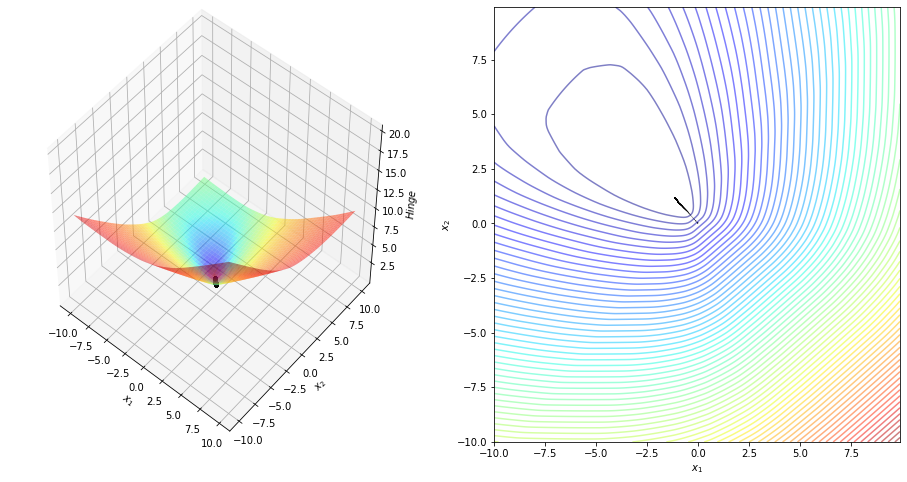

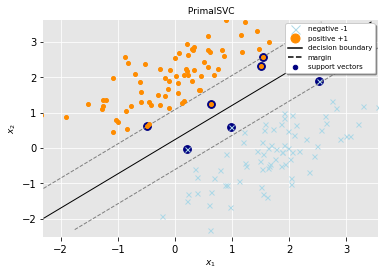

svc accuracy score is 1.0
svc found 7 support vectors from 150 examples
svc w is [-1.14131263  1.18215449]
svc b is -0.28033266135794443

1.21 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


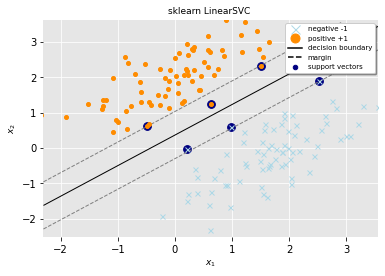

sklearn svc accuracy score is 1.0
sklearn svc found 6 support vectors from 150 examples
sklearn svc w is [[-1.29506521  1.50188528]]
sklearn svc b is [-0.54931117]


In [5]:
X, y = generate_linearly_separable_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svc = PrimalSVC(loss=hinge, optimizer=AdaGrad, learning_rate_init=0.1, 
                early_stopping=False, validation_split=0.1, verbose=50)
custom_time = %timeit -n1 -r1 -o svc.fit(X_train, y_train)
plot_trajectory_optimization(svc.loss, svc.optimizer, -10, 10, -10, 10)
plot_svm_hyperplane(svc, X_train, y_train)
custom_accuracy = svc.score(X_test, y_test)
print(f'svc accuracy score is {custom_accuracy}')
custom_support_vectors = np.argwhere(np.abs(svc.decision_function(X_train)) <= 1).ravel()
print(f'svc found {len(custom_support_vectors)} support vectors from {len(X_train)} examples')
print(f'svc w is {svc.coef_}')
print(f'svc b is {svc.intercept_}')

print()

svc = SKLinearSVC(loss='hinge')
sklearn_time = %timeit -n1 -r1 -o svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
sklearn_accuracy = svc.score(X_test, y_test)
print(f'sklearn svc accuracy score is {sklearn_accuracy}')
sklearn_support_vectors = np.argwhere(np.abs(svc.decision_function(X_train)) <= 1).ravel()
print(f'sklearn svc found {len(sklearn_support_vectors)} support vectors from {len(X_train)} examples')
print(f'sklearn svc w is {svc.coef_}')
print(f'sklearn svc b is {svc.intercept_}')

In [6]:
results['formulation'].append('primal')
results['loss'].append('hinge')
results['kernel'].append('linear')
results['implementation'].append('custom')
results['time'].append(custom_time.average)
results['score'].append(custom_accuracy)
results['support_vectors'].append(len(custom_support_vectors))

results['formulation'].append('primal')
results['loss'].append('hinge')
results['kernel'].append('linear')
results['implementation'].append('sklearn')
results['time'].append(sklearn_time.average)
results['score'].append(sklearn_accuracy)
results['support_vectors'].append(len(sklearn_support_vectors))

epoch	iter	 cost	
   0	   0	 1.0000e+00 - val_loss:  1.0000e+00 - acc:  0.4963 - val_acc:  0.6000
  50	  50	 1.1444e-02 - val_loss:  6.5260e-02 - acc:  1.0000 - val_acc:  1.0000
 100	 100	 1.2044e-02 - val_loss:  8.0084e-02 - acc:  1.0000 - val_acc:  1.0000
 150	 150	 1.2330e-02 - val_loss:  9.0290e-02 - acc:  1.0000 - val_acc:  1.0000
 200	 200	 1.2943e-02 - val_loss:  9.8867e-02 - acc:  1.0000 - val_acc:  1.0000
 250	 250	 1.3597e-02 - val_loss:  1.0590e-01 - acc:  1.0000 - val_acc:  1.0000
 300	 300	 1.4072e-02 - val_loss:  1.1084e-01 - acc:  1.0000 - val_acc:  1.0000
 350	 350	 1.4220e-02 - val_loss:  1.1228e-01 - acc:  1.0000 - val_acc:  1.0000
 400	 400	 1.4290e-02 - val_loss:  1.1350e-01 - acc:  1.0000 - val_acc:  1.0000
 450	 450	 1.4361e-02 - val_loss:  1.1470e-01 - acc:  1.0000 - val_acc:  1.0000
 500	 500	 1.4433e-02 - val_loss:  1.1587e-01 - acc:  1.0000 - val_acc:  1.0000
 550	 550	 1.4547e-02 - val_loss:  1.1711e-01 - acc:  1.0000 - val_acc:  1.0000
 600	 600	 1.4603e-02 

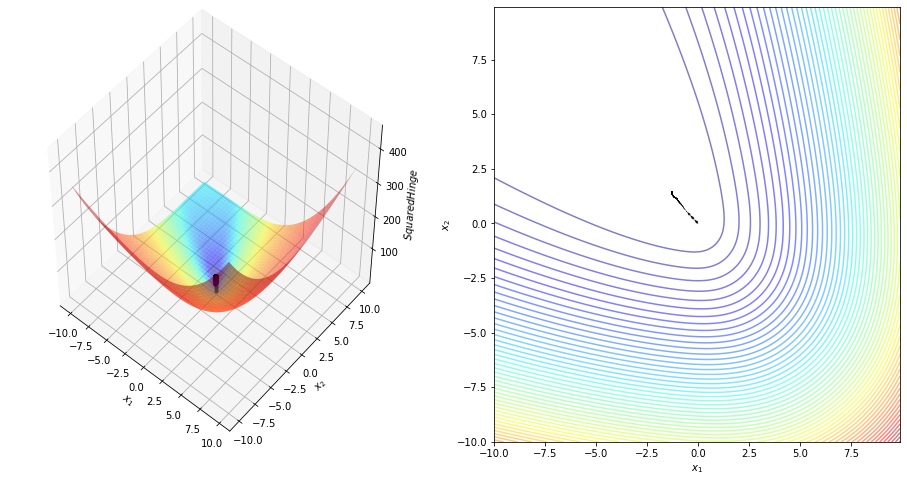

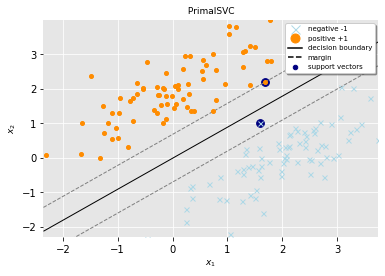

svc accuracy score is 1.0
svc found 2 support vectors from 150 examples
svc w is [-1.29963943  1.44727952]
svc b is 0.017845319376154557

945 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


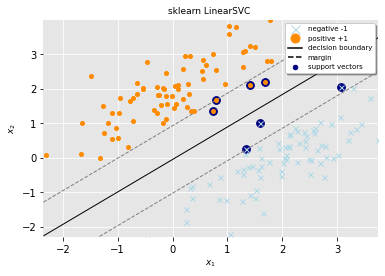

sklearn svc accuracy score is 1.0
sklearn svc found 7 support vectors from 150 examples
sklearn svc w is [[-0.96207544  1.02350195]]
sklearn svc b is [0.04889205]


In [7]:
X, y = generate_linearly_separable_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svc = PrimalSVC(loss=squared_hinge, optimizer=StochasticGradientDescent, learning_rate_init=0.1, 
                early_stopping=False, validation_split=0.1, verbose=50)
custom_time = %timeit -n1 -r1 -o svc.fit(X_train, y_train)
plot_trajectory_optimization(svc.loss, svc.optimizer, -10, 10, -10, 10)
plot_svm_hyperplane(svc, X_train, y_train)
custom_accuracy = svc.score(X_test, y_test)
print(f'svc accuracy score is {custom_accuracy}')
custom_support_vectors = np.argwhere(np.abs(svc.decision_function(X_train)) <= 1).ravel()
print(f'svc found {len(custom_support_vectors)} support vectors from {len(X_train)} examples')
print(f'svc w is {svc.coef_}')
print(f'svc b is {svc.intercept_}')

print()

svc = SKLinearSVC(loss='squared_hinge')
sklearn_time = %timeit -n1 -r1 -o svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
sklearn_accuracy = svc.score(X_test, y_test)
print(f'sklearn svc accuracy score is {sklearn_accuracy}')
sklearn_support_vectors = np.argwhere(np.abs(svc.decision_function(X_train)) <= 1).ravel()
print(f'sklearn svc found {len(sklearn_support_vectors)} support vectors from {len(X_train)} examples')
print(f'sklearn svc w is {svc.coef_}')
print(f'sklearn svc b is {svc.intercept_}')

In [8]:
results['formulation'].append('primal')
results['loss'].append('squared_hinge')
results['kernel'].append('linear')
results['implementation'].append('custom')
results['time'].append(custom_time.average)
results['score'].append(custom_accuracy)
results['support_vectors'].append(len(custom_support_vectors))

results['formulation'].append('primal')
results['loss'].append('squared_hinge')
results['kernel'].append('linear')
results['implementation'].append('sklearn')
results['time'].append(sklearn_time.average)
results['score'].append(sklearn_accuracy)
results['support_vectors'].append(len(sklearn_support_vectors))

In order to cater for the constraints in this minimization, we need to allocate them Lagrange multipliers $\alpha$, where $\alpha_{i}\geq 0 \ \forall_{i}$:

$$
\begin{align*}
    \mathcal{W}(w,b,\alpha) \displaystyle &= \frac{1}{2}\Vert w\Vert^{2}-\alpha[y_{i}(\langle w, x_i \rangle +b)-1 \ \forall_{i}] \tag{1.9} \\
    &= \displaystyle \frac{1}{2}\Vert w\Vert^{2}-\sum_{i=1}^{n}\alpha_{i}[y_{i}(\langle w, x_i \rangle +b)-1] \tag{1.10} \\
    &= \displaystyle \frac{1}{2}\Vert w\Vert^{2}-\sum_{i=1}^{n}\alpha_{i}y_{i}(\langle w, x_i \rangle +b)+\sum_{i=1}^{n}\alpha_{i} \tag{1.11}
\end{align*}
$$

We wish to find the $w$ and $b$ which minimizes, and the $\alpha$ which maximizes $\mathcal{W}$ (whilst keeping $\alpha_{i}\geq 0 \ \forall_{i}$). We can do this by differentiating $\mathcal{W}$ with respect to $w$ and $b$ and setting the derivatives to zero:

$$
\begin{equation}
    \displaystyle \frac{\partial \mathcal{W}}{\partial w}=0\Rightarrow w=\sum_{i=1}^{n}\alpha_{i}y_i x_i \tag{1.12}
\end{equation}
$$
$$
\begin{equation}
    \displaystyle \frac{\partial \mathcal{W}}{\partial b}=0\Rightarrow\sum_{i=1}^{n}\alpha_{i}y_{i}=0 \tag{1.13}
\end{equation}
$$

Substituting (1.12) and (1.13) into (1.11) gives a new formulation which, being dependent on $\alpha$, we need to maximize:

$$
\begin{align*}
    \mathcal{W}(\alpha) \displaystyle &= \sum_{i=1}^{n}\alpha_{i} - \frac{1}{2}\sum_{i,j}\alpha_{i}\alpha_{j}y_{i}y_{j} \langle x_i, x_j \rangle \ \text{subject to} \ \alpha_{i}\geq 0 \ \forall_{i}, \displaystyle \sum_{i=1}^{n}\alpha_{i}y_{i}=0 \tag{1.14} \\
    &= \displaystyle \sum_{i=1}^{n}\alpha_{i} - \frac{1}{2}\sum_{i,j}\alpha_{i}Q_{ij}\alpha_{j} \ \text{where} \ Q_{ij} = y_{i}y_{j} \langle x_{i}, x_{j} \rangle \tag{1.15} \\
    &= \sum_{i=1}^{n}\alpha_{i} - \frac{1}{2}\alpha^{T}Q\alpha \ \text{subject to} \ \alpha_{i}\geq 0 \ \forall_{i}, \displaystyle \sum_{i=1}^{n}\alpha_{i}y_{i}=0 \tag{1.16}
\end{align*}
$$

This new formulation $\mathcal{W}$ is referred to as the *Wolfe dual* form of the *primary* formulation. It is worth noting that the dual form requires only the dot product of each input vector $x_{i}$ to be calculated, this is important for the *kernel trick* discussed later.

Having moved from minimizing $\mathcal{W}(w,b,\alpha)$ to maximizing $\mathcal{W}(\alpha)$, we need to minimize:

$$
\begin{equation}
    \begin{aligned}
        \min_{\alpha} \quad & \frac{1}{2} \alpha^{T}Q\alpha-q^T\alpha \\
            \textrm{subject to} \quad & \alpha_{i}\geq 0 \ \forall_{i} \\ & y^T\alpha=0
    \end{aligned} \tag{1.17}
\end{equation}
$$

where $q$ is a vector of all ones.

This is a convex quadratic optimization problem, and we run a QP solver which will return $\alpha$ and from (1.12) will give us $w$. What remains is to calculate $b.$

Any data point satisfying (1.13) which is a Support Vector $x_{s}$ will have the form:

$$y_{s}(\langle w, x_{s} \rangle +b)=1$$

Substituting in (1.12):

$$y_{s}(\sum_{m\in S}\alpha_{m}y_{m} \langle x_{m}, x_{s} \rangle +b)=1$$

Where $S$ denotes the set of indices of the support vectors. $S$ is determined by finding the indices $i$ where $\alpha_{i}>0$. Multiplying through by $y_{s}$ and then using $y_{s}^{2}=1$ from (1.1) and (1.2):

$$y_{s}^{2}(\sum_{m\in S}\alpha_{m}y_{m} \langle x_{m}, x_{s} \rangle +b)=y_{s}$$
$$b=y_{s}-\sum_{m\in S}\alpha_{m}y_{m} \langle x_{m}, x_{s} \rangle$$

Instead of using an arbitrary support vector $x_{s}$, it is better to take an average over all of the support vectors in $S$:

$$
\begin{equation}
    b=\displaystyle \frac{1}{N_{s}}\sum_{s\in S}(y_{s}-\sum_{m\in S}\alpha_{m}y_{m} \langle x_{m}, x_{s} \rangle) \tag{1.18}
\end{equation}
$$

We now have the variables $w$ and $b$ that define our separating hyperplane's optimal orientation and hence our support vector machine. Each new point $x'$ is classified by evaluating:

$$
\begin{equation}
    y'=\displaystyle \operatorname{sgn}(\sum_{i=1}^{n}\alpha_i y_i\langle x_{i}, x' \rangle+b) \tag{1.19}
\end{equation}
$$

In [10]:
from optiml.ml.svm import DualSVC
from optiml.ml.svm.smo import SMOClassifier
from optiml.ml.svm.kernels import linear
from optiml.ml.utils import generate_linearly_separable_data, plot_svm_hyperplane

from sklearn.svm import SVC as SKLSVC
from sklearn.model_selection import train_test_split

iter	 cost
   0	-1.0779e+00
   1	-1.5483e+00
   2	-1.6678e+00
   3	-1.6704e+00
   4	-1.6715e+00
   5	-1.6716e+00
   6	-1.6716e+00
   7	-1.6716e+00

65.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


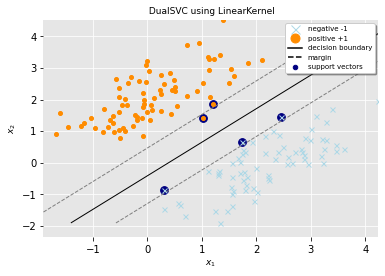

svc accuracy score is 1.0
svc found 5 support vectors from 150 examples
svc w is [-1.20822603  1.1370006 ]
svc b is 0.47198545075880427

     pcost       dcost       gap    pres   dres
 0: -1.2313e+01 -2.4732e+02  1e+03  2e+00  6e-15
 1: -6.1975e+00 -1.1579e+02  2e+02  2e-01  3e-15
 2: -7.4276e-01 -1.5553e+01  2e+01  2e-02  4e-15
 3: -8.7543e-01 -4.5714e+00  5e+00  4e-03  2e-15
 4: -1.1573e+00 -3.0961e+00  2e+00  2e-03  1e-15
 5: -1.4536e+00 -2.4839e+00  1e+00  4e-04  1e-15
 6: -1.5079e+00 -2.2086e+00  7e-01  1e-04  1e-15
 7: -1.6782e+00 -1.9929e+00  3e-01  2e-16  1e-15
 8: -1.8151e+00 -1.8265e+00  1e-02  2e-16  2e-15
 9: -1.8200e+00 -1.8201e+00  1e-04  2e-16  2e-15
10: -1.8200e+00 -1.8200e+00  1e-06  2e-16  2e-15
Optimal solution found.

44.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


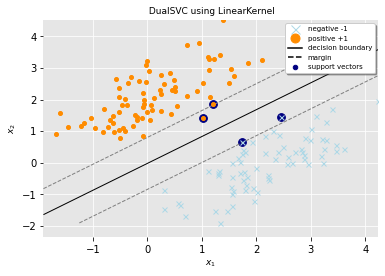

cvxopt svc accuracy score is 1.0
cvxopt svc found 4 support vectors from 150 examples
cvxopt svc w is [-1.03424333  1.21599008]
cvxopt svc b is 0.02751430600460536

1.02 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


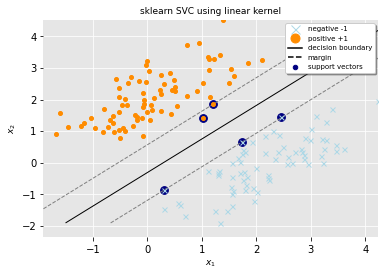

sklearn svc accuracy score is 1.0
sklearn svc found 5 support vectors from 150 examples
sklearn svc w is [[-1.20855412  1.13767432]]
sklearn svc b is [0.35489104]


In [11]:
X, y = generate_linearly_separable_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svc = DualSVC(kernel=linear, optimizer=SMOClassifier, verbose=True)
custom_time = %timeit -n1 -r1 -o svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
custom_accuracy = svc.score(X_test, y_test)
print(f'svc accuracy score is {custom_accuracy}')
custom_support_vectors = len(svc.support_)
print(f'svc found {custom_support_vectors} support vectors from {len(X_train)} examples')
print(f'svc w is {svc.coef_}')
print(f'svc b is {svc.intercept_}')

print()

svc = DualSVC(kernel=linear, optimizer='cvxopt', verbose=True)
cvxopt_time = %timeit -n1 -r1 -o svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
cvxopt_accuracy = svc.score(X_test, y_test)
print(f'cvxopt svc accuracy score is {cvxopt_accuracy}')
cvxopt_support_vectors = len(svc.support_)
print(f'cvxopt svc found {cvxopt_support_vectors} support vectors from {len(X_train)} examples')
print(f'cvxopt svc w is {svc.coef_}')
print(f'cvxopt svc b is {svc.intercept_}')

print()

svc = SKLSVC(kernel='linear')
sklearn_time = %timeit -n1 -r1 -o svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
sklearn_accuracy = svc.score(X_test, y_test)
print(f'sklearn svc accuracy score is {sklearn_accuracy}')
sklearn_support_vectors = len(svc.support_)
print(f'sklearn svc found {sklearn_support_vectors} support vectors from {len(X_train)} examples')
print(f'sklearn svc w is {svc.coef_}')
print(f'sklearn svc b is {svc.intercept_}')

In [12]:
results['formulation'].append('wolfe_dual')
results['loss'].append('hinge')
results['kernel'].append('linear')
results['implementation'].append('custom')
results['time'].append(custom_time.average)
results['score'].append(custom_accuracy)
results['support_vectors'].append(custom_support_vectors)

results['formulation'].append('wolfe_dual')
results['loss'].append('hinge')
results['kernel'].append('linear')
results['implementation'].append('cvxopt')
results['time'].append(cvxopt_time.average)
results['score'].append(cvxopt_accuracy)
results['support_vectors'].append(cvxopt_support_vectors)

results['formulation'].append('wolfe_dual')
results['loss'].append('hinge')
results['kernel'].append('linear')
results['implementation'].append('sklearn')
results['time'].append(sklearn_time.average)
results['score'].append(sklearn_accuracy)
results['support_vectors'].append(sklearn_support_vectors)

In order to relax the constraints in the *Wolfe dual* formulation (1.17) to define the problem as a *Lagrangian dual* relaxation by embedding them into objective function we need to allocate the Lagrangian multipliers $\lambda \geq 0$:

$$
\begin{align*}
    \mathcal{L}(\alpha, \lambda) &= \frac{1}{2} \alpha^{T}Q\alpha-q^T\alpha - \lambda^T \alpha \\
    &= \displaystyle \frac{1}{2} \alpha^{T}Q\alpha + (q - \lambda)^T \alpha \tag{1.20}
\end{align*}
$$

In [13]:
from optiml.ml.svm import DualSVC
from optiml.ml.svm.kernels import linear
from optiml.ml.utils import generate_linearly_separable_data, plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.model_selection import train_test_split

epoch	iter	 cost	
   0	   0	-2.1722e-01	ub: -2.1722e-01 - pcost:  2.1722e-01 - gap:  4.3443e-01
   1	   1	 1.4752e+01	ub:  2.1722e-01 - pcost:  2.1722e-01 - gap:  0.0000e+00

17.7 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


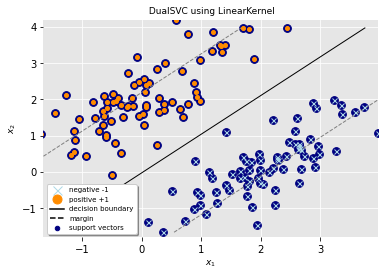

svc accuracy score is 1.0
svc found 150 support vectors from 150 examples
svc w is [-0.47998532  0.45171278]
svc b is 0.007924288352470964


In [14]:
X, y = generate_linearly_separable_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svc = DualSVC(kernel=linear, optimizer=AdaGrad, verbose=True)
custom_time = %timeit -n1 -r1 -o svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
custom_accuracy = svc.score(X_test, y_test)
print(f'svc accuracy score is {custom_accuracy}')
custom_support_vectors = len(svc.support_)
print(f'svc found {custom_support_vectors} support vectors from {len(X_train)} examples')
print(f'svc w is {svc.coef_}')
print(f'svc b is {svc.intercept_}')

In [15]:
results['formulation'].append('lagrangian_dual')
results['loss'].append('hinge')
results['kernel'].append('linear')
results['implementation'].append('custom')
results['time'].append(custom_time.average)
results['score'].append(custom_accuracy)
results['support_vectors'].append(custom_support_vectors)

#### Nonlinearly Separable Binary Classification

In order to extend the SVM methodology to handle data that is not fully linearly separable, we relax the constraints for (1.1) and (1.2) slightly to allow for misclassified points. This is done by introducing a positive slack variable $\xi_{i}, i=1$, $\dots$, $n$ :

$$
\begin{equation}
    \langle w, x_i \rangle +b\geq+1-\xi_{i} \ \text{for} \ y_{i}=+1 \tag{2.1}
\end{equation}
$$
$$
\begin{equation}
    \langle w, x_i \rangle +b\leq-1+\xi_{i} \ \text{for} \ y_{i}=-1 \tag{2.2}
\end{equation}
$$ 

$$\text{where} \ \xi_{i}\geq 0 \ \forall_{i}$$

Which can be combined into:

$$
\begin{equation}
    y_{i}(\langle w, x_i \rangle +b) \geq 1 - \xi_{i} \ \forall_{i} \text{where} \ \xi_{i}\geq 0 \ \forall_{i} \tag{2.3}
\end{equation}
$$

<img src="./img/svc_soft.png" width=600/>

In this *soft margin* SVM, data points on the incorrect side of the margin boundary have a penalty that increases with the distance from it. As we are trying to reduce the number of misclassifications, a sensible way to adapt our objective function (1.7) from previously, is to find:

$$
\begin{equation}
    \begin{aligned}
        \min_{w,b,\xi} \quad & \frac{1}{2} \Vert w \Vert^2 + C \sum_{i=1}^{n} \xi_{i} \\
            \textrm{subject to} \quad & y_{i}(\langle w, x_i \rangle +b) \geq 1 - \xi_{i} \ \forall_{i} \\ & \xi_{i} \geq 0 \ \forall_{i}
    \end{aligned} \tag{2.4}
\end{equation}
$$

which can be equivalently formulated as: 

$$
\begin{equation}
    \min_{w,b} \frac{1}{2} \Vert w \Vert^2 + C 
        \begin{cases}
            \sum_{i=1}^n \max(0, y_i (\langle w, x_i \rangle + b)) & \text{if using L1 loss} \\
            \sum_{i=1}^n \max(0, y_i (\langle w, x_i \rangle + b))^2 & \text{if using L2 loss}
          \end{cases} \tag{2.5}
\end{equation}
$$

where we make use of the Hinge (L1 loss) and squared Hinge (L2 loss) loss respectively.

In [16]:
from optiml.ml.svm import PrimalSVC
from optiml.ml.svm.losses import hinge, squared_hinge
from optiml.ml.utils import generate_linearly_separable_overlap_data, plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad, StochasticGradientDescent
from optiml.opti.utils import plot_trajectory_optimization

from sklearn.svm import LinearSVC as SKLinearSVC
from sklearn.model_selection import train_test_split

epoch	iter	 cost	
   0	   0	 1.0000e+00 - val_loss:  1.0000e+00 - acc:  0.5037 - val_acc:  0.4667
  50	  50	 1.3624e-01 - val_loss:  5.9969e-02 - acc:  0.9704 - val_acc:  1.0000
 100	 100	 1.2123e-01 - val_loss:  6.0762e-02 - acc:  0.9630 - val_acc:  1.0000
 150	 150	 1.1469e-01 - val_loss:  6.7669e-02 - acc:  0.9630 - val_acc:  1.0000
 200	 200	 1.1193e-01 - val_loss:  6.6793e-02 - acc:  0.9630 - val_acc:  1.0000
 250	 250	 1.0981e-01 - val_loss:  6.7971e-02 - acc:  0.9704 - val_acc:  1.0000
 300	 300	 1.0847e-01 - val_loss:  7.2211e-02 - acc:  0.9630 - val_acc:  1.0000
 350	 350	 1.0757e-01 - val_loss:  7.5777e-02 - acc:  0.9630 - val_acc:  1.0000
 400	 400	 1.0707e-01 - val_loss:  7.8579e-02 - acc:  0.9630 - val_acc:  1.0000
 450	 450	 1.0673e-01 - val_loss:  8.0860e-02 - acc:  0.9630 - val_acc:  1.0000
 500	 500	 1.0656e-01 - val_loss:  8.2876e-02 - acc:  0.9630 - val_acc:  1.0000
 550	 550	 1.0635e-01 - val_loss:  8.4851e-02 - acc:  0.9630 - val_acc:  1.0000
 600	 600	 1.0618e-01 

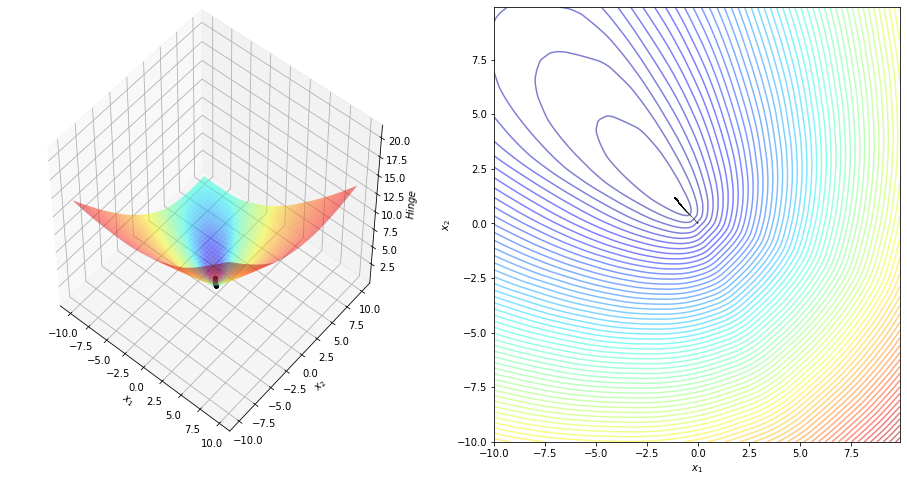

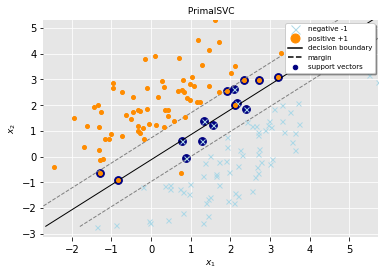

svc accuracy score is 0.94
svc found 15 support vectors from 150 examples
svc w is [-1.14889684  1.18075001]
svc b is 0.14096031034338014

1.69 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


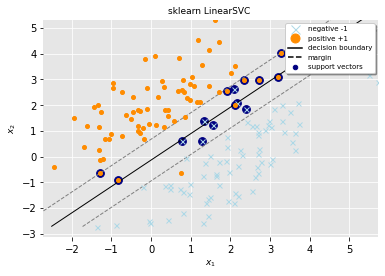

sklearn svc accuracy score is 0.94
sklearn svc found 15 support vectors from 150 examples
sklearn svc w is [[-1.26694908  1.23422345]]
sklearn svc b is [0.16112321]


In [17]:
X, y = generate_linearly_separable_overlap_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svc = PrimalSVC(loss=hinge, optimizer=AdaGrad, learning_rate_init=0.1, 
                early_stopping=False, validation_split=0.1, verbose=50)
custom_time = %timeit -n1 -r1 -o svc.fit(X_train, y_train)
plot_trajectory_optimization(svc.loss, svc.optimizer, -10, 10, -10, 10)
plot_svm_hyperplane(svc, X_train, y_train)
custom_accuracy = svc.score(X_test, y_test)
print(f'svc accuracy score is {custom_accuracy}')
custom_support_vectors = np.argwhere(np.abs(svc.decision_function(X_train)) <= 1).ravel()
print(f'svc found {len(custom_support_vectors)} support vectors from {len(X_train)} examples')
print(f'svc w is {svc.coef_}')
print(f'svc b is {svc.intercept_}')

print()

svc = SKLinearSVC(loss='hinge')
sklearn_time = %timeit -n1 -r1 -o svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
sklearn_accuracy = svc.score(X_test, y_test)
print(f'sklearn svc accuracy score is {sklearn_accuracy}')
sklearn_support_vectors = np.argwhere(np.abs(svc.decision_function(X_train)) <= 1).ravel()
print(f'sklearn svc found {len(sklearn_support_vectors)} support vectors from {len(X_train)} examples')
print(f'sklearn svc w is {svc.coef_}')
print(f'sklearn svc b is {svc.intercept_}')

In [18]:
results['formulation'].append('primal')
results['loss'].append('hinge')
results['kernel'].append('linear')
results['implementation'].append('custom')
results['time'].append(custom_time.average)
results['score'].append(custom_accuracy)
results['support_vectors'].append(len(custom_support_vectors))

results['formulation'].append('primal')
results['loss'].append('hinge')
results['kernel'].append('linear')
results['implementation'].append('sklearn')
results['time'].append(sklearn_time.average)
results['score'].append(sklearn_accuracy)
results['support_vectors'].append(len(sklearn_support_vectors))

epoch	iter	 cost	
   0	   0	 1.0000e+00 - val_loss:  1.0000e+00 - acc:  0.4815 - val_acc:  0.6667
  50	  50	 1.2866e-01 - val_loss:  1.5177e-01 - acc:  0.9556 - val_acc:  0.9333
 100	 100	 1.3480e-01 - val_loss:  1.6168e-01 - acc:  0.9630 - val_acc:  0.9333
 150	 150	 1.4009e-01 - val_loss:  1.7221e-01 - acc:  0.9630 - val_acc:  0.9333
 200	 200	 1.4336e-01 - val_loss:  1.7759e-01 - acc:  0.9630 - val_acc:  0.9333
 250	 250	 1.4459e-01 - val_loss:  1.7934e-01 - acc:  0.9630 - val_acc:  0.9333
 300	 300	 1.4449e-01 - val_loss:  1.7890e-01 - acc:  0.9630 - val_acc:  0.9333
 350	 350	 1.4436e-01 - val_loss:  1.7873e-01 - acc:  0.9630 - val_acc:  0.9333
 400	 400	 1.4356e-01 - val_loss:  1.7723e-01 - acc:  0.9630 - val_acc:  0.9333
 450	 450	 1.4354e-01 - val_loss:  1.7716e-01 - acc:  0.9630 - val_acc:  0.9333
 500	 500	 1.4343e-01 - val_loss:  1.7703e-01 - acc:  0.9630 - val_acc:  0.9333
 550	 550	 1.4461e-01 - val_loss:  1.7923e-01 - acc:  0.9630 - val_acc:  0.9333
 600	 600	 1.4459e-01 

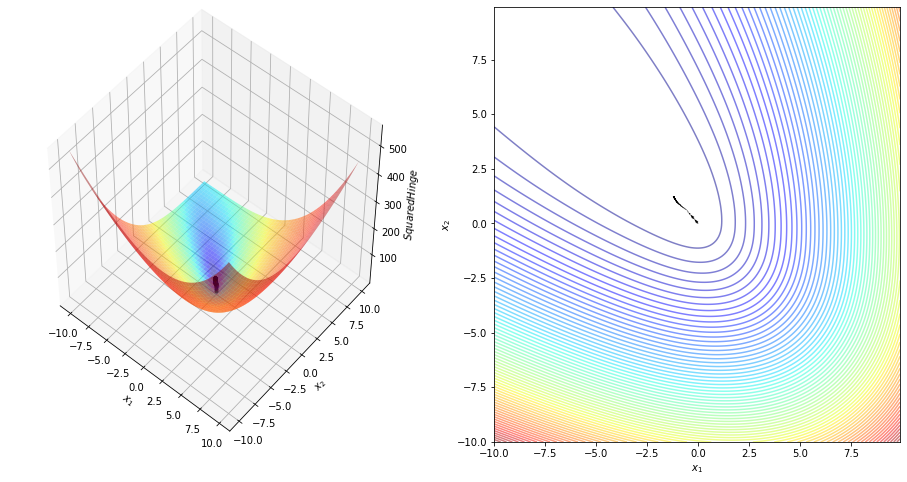

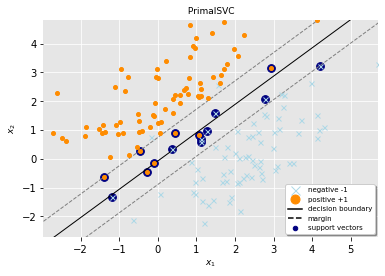

svc accuracy score is 0.98
svc found 15 support vectors from 150 examples
svc w is [-1.20240747  1.22314054]
svc b is 0.09346074216912001

1.92 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


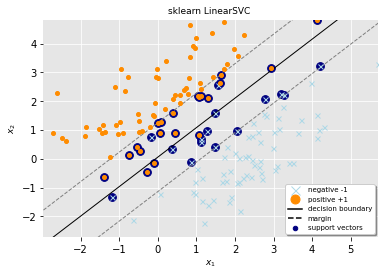

sklearn svc accuracy score is 0.98
sklearn svc found 35 support vectors from 150 examples
sklearn svc w is [[-0.85531889  0.83435495]]
sklearn svc b is [-0.04863566]


In [19]:
X, y = generate_linearly_separable_overlap_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svc = PrimalSVC(loss=squared_hinge, optimizer=StochasticGradientDescent, learning_rate_init=0.1, 
                early_stopping=False, validation_split=0.1, verbose=50)
custom_time = %timeit -n1 -r1 -o svc.fit(X_train, y_train)
plot_trajectory_optimization(svc.loss, svc.optimizer, -10, 10, -10, 10)
plot_svm_hyperplane(svc, X_train, y_train)
custom_accuracy = svc.score(X_test, y_test)
print(f'svc accuracy score is {custom_accuracy}')
custom_support_vectors = np.argwhere(np.abs(svc.decision_function(X_train)) <= 1).ravel()
print(f'svc found {len(custom_support_vectors)} support vectors from {len(X_train)} examples')
print(f'svc w is {svc.coef_}')
print(f'svc b is {svc.intercept_}')

print()

svc = SKLinearSVC(loss='squared_hinge')
sklearn_time = %timeit -n1 -r1 -o svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
sklearn_accuracy = svc.score(X_test, y_test)
print(f'sklearn svc accuracy score is {sklearn_accuracy}')
sklearn_support_vectors = np.argwhere(np.abs(svc.decision_function(X_train)) <= 1).ravel()
print(f'sklearn svc found {len(sklearn_support_vectors)} support vectors from {len(X_train)} examples')
print(f'sklearn svc w is {svc.coef_}')
print(f'sklearn svc b is {svc.intercept_}')

In [20]:
results['formulation'].append('primal')
results['loss'].append('squared_hinge')
results['kernel'].append('linear')
results['implementation'].append('custom')
results['time'].append(custom_time.average)
results['score'].append(custom_accuracy)
results['support_vectors'].append(len(custom_support_vectors))

results['formulation'].append('primal')
results['loss'].append('squared_hinge')
results['kernel'].append('linear')
results['implementation'].append('sklearn')
results['time'].append(sklearn_time.average)
results['score'].append(sklearn_accuracy)
results['support_vectors'].append(len(sklearn_support_vectors))

Where the parameter $C$ controls the trade-off between the slack variable penalty and the size of the margin. Reformulating as a Lagrangian, which as before we need to minimize with respect to $w$, $b$ and $\xi_{i}$ and maximize with respect to $\alpha$ (where $\alpha_{i} \geq 0, \mu_{i} \geq 0 \ \forall_{i}$):

$$
\begin{equation}
    \mathcal{W}(w,b,\xi,\alpha) \displaystyle = \frac{1}{2}\Vert w\Vert^{2}+C\sum_{i=1}^n\xi_{i}-\sum_{i=1}^n\alpha_{i}[y_{i}(\langle w, {x}_{i} \rangle+b)-1+\xi_{i}]-\sum_{i=1}^n\mu_{i}\xi_{i} \tag{2.6}
\end{equation}
$$

Differentiating with respect to $w$, $b$ and $\xi_{i}$ and setting the derivatives to zero:

$$
\begin{equation}
    \displaystyle \frac{\partial \mathcal{W}}{\partial w}=0\Rightarrow w=\sum_{i=1}^{n}\alpha_{i}y_{i}x_i \tag{2.7}
\end{equation}
$$
$$
\begin{equation}
    \displaystyle \frac{\partial \mathcal{W}}{\partial b}=0\Rightarrow\sum_{i=1}^{n}\alpha_{i}y_{i}=0 \tag{2.8}
\end{equation}
$$
$$
\begin{equation}
    \displaystyle \frac{\partial \mathcal{W}}{\partial\xi_{i}}=0\Rightarrow C=\alpha_{i}+\mu_{i} \tag{2.9}
\end{equation}
$$

Substituting these in, $\mathcal{W}(\alpha)$ has the same form as (1.16) before. However (2.9) together with $\mu_{i}\geq 0 \ \forall_{i}$, implies that $\alpha\leq C$. We therefore need to find:

$$
\begin{equation}
    \begin{aligned}
        \min_{\alpha} \quad & \frac{1}{2}\alpha^{T}Q\alpha-q^T\alpha \\
            \textrm{subject to} \quad & 0\leq\alpha_{i}\leq C \ \forall_{i} \\ & y^T\alpha=0 
    \end{aligned} \tag{2.10}
\end{equation}
$$

where $q$ is a vector of all ones.

$b$ is then calculated in the same way as in (1.7) before, though in this instance the set of support vectors used to calculate $b$ is determined by finding the indices $i$ where $0\leq\alpha_{i}\leq C$.

In [21]:
from optiml.ml.svm import DualSVC
from optiml.ml.svm.smo import SMOClassifier
from optiml.ml.svm.kernels import linear
from optiml.ml.utils import generate_linearly_separable_overlap_data, plot_svm_hyperplane

from sklearn.svm import SVC as SKLSVC
from sklearn.model_selection import train_test_split

iter	 cost
   0	-1.1855e+00
   1	-1.2953e+00
   2	-1.3156e+00
   3	-1.3186e+00
   4	-1.3189e+00
   5	-1.6177e+00
   6	-1.6228e+00
   7	-1.6249e+00
   8	-1.6250e+00
   9	-1.7050e+00
  10	-1.7119e+00
  11	-1.7122e+00
  12	-1.7125e+00
  13	-1.7129e+00
  14	-1.7130e+00
  15	-1.7131e+00
  16	-1.7131e+00
  17	-1.7131e+00

129 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


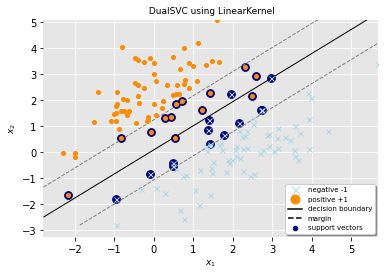

svc accuracy score is 0.98
svc found 26 support vectors from 150 examples
svc w is [-0.80046006  0.86507531]
svc b is -0.08150925734756588

     pcost       dcost       gap    pres   dres
 0: -1.4227e+01 -2.4724e+01  7e+02  2e+01  4e-15
 1: -2.7615e+00 -2.2467e+01  6e+01  1e+00  4e-15
 2: -1.4331e+00 -8.7634e+00  9e+00  8e-02  1e-15
 3: -1.4356e+00 -2.5657e+00  1e+00  1e-02  1e-15
 4: -1.6665e+00 -1.9133e+00  3e-01  2e-03  7e-16
 5: -1.7326e+00 -1.7949e+00  7e-02  3e-04  7e-16
 6: -1.7499e+00 -1.7675e+00  2e-02  9e-05  6e-16
 7: -1.7562e+00 -1.7583e+00  2e-03  2e-16  8e-16
 8: -1.7572e+00 -1.7572e+00  2e-05  2e-16  8e-16
 9: -1.7572e+00 -1.7572e+00  2e-07  2e-16  8e-16
Optimal solution found.

91.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


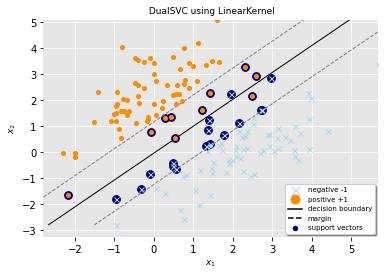

cvxopt svc accuracy score is 1.0
cvxopt svc found 26 support vectors from 150 examples
cvxopt svc w is [-0.85933398  0.83157778]
cvxopt svc b is 0.027261240584109225

1.29 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


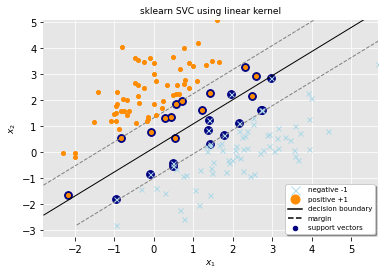

sklearn svc accuracy score is 1.0
sklearn svc found 26 support vectors from 150 examples
sklearn svc w is [[-0.80033874  0.86457433]]
sklearn svc b is [-0.14553441]


In [22]:
X, y = generate_linearly_separable_overlap_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svc = DualSVC(kernel=linear, C=0.1, optimizer=SMOClassifier, verbose=True)
custom_time = %timeit -n1 -r1 -o svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
print(f'svc accuracy score is {svc.score(X_test, y_test)}')
custom_support_vectors = len(svc.support_)
print(f'svc found {custom_support_vectors} support vectors from {len(X_train)} examples')
print(f'svc w is {svc.coef_}')
print(f'svc b is {svc.intercept_}')

print()

svc = DualSVC(kernel=linear, C=0.1, optimizer='cvxopt', verbose=True)
cvxopt_time = %timeit -n1 -r1 -o svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
print(f'cvxopt svc accuracy score is {svc.score(X_test, y_test)}')
cvxopt_support_vectors = len(svc.support_)
print(f'cvxopt svc found {cvxopt_support_vectors} support vectors from {len(X_train)} examples')
print(f'cvxopt svc w is {svc.coef_}')
print(f'cvxopt svc b is {svc.intercept_}')

print()

svc = SKLSVC(kernel='linear', C=0.1)
sklearn_time = %timeit -n1 -r1 -o svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
print(f'sklearn svc accuracy score is {svc.score(X_test, y_test)}')
sklearn_support_vectors = len(svc.support_)
print(f'sklearn svc found {sklearn_support_vectors} support vectors from {len(X_train)} examples')
print(f'sklearn svc w is {svc.coef_}')
print(f'sklearn svc b is {svc.intercept_}')

In [23]:
results['formulation'].append('wolfe_dual')
results['loss'].append('hinge')
results['kernel'].append('linear')
results['implementation'].append('custom')
results['time'].append(custom_time.average)
results['score'].append(custom_accuracy)
results['support_vectors'].append(custom_support_vectors)

results['formulation'].append('wolfe_dual')
results['loss'].append('hinge')
results['kernel'].append('linear')
results['implementation'].append('cvxopt')
results['time'].append(cvxopt_time.average)
results['score'].append(cvxopt_accuracy)
results['support_vectors'].append(cvxopt_support_vectors)

results['formulation'].append('wolfe_dual')
results['loss'].append('hinge')
results['kernel'].append('linear')
results['implementation'].append('sklearn')
results['time'].append(sklearn_time.average)
results['score'].append(sklearn_accuracy)
results['support_vectors'].append(sklearn_support_vectors)

In order to relax the box-constraints in the *Wolfe dual* formulation (2.10) to define the problem as a *Lagrangian dual* relaxation by embedding them into objective function we need to allocate the Lagrangian multipliers $\lambda$:

$$
\begin{align*}
    \mathcal{L}(\alpha, \lambda_+, \lambda_-) &= \frac{1}{2} \alpha^{T}Q\alpha-q^T\alpha - \lambda_+^T (ub - \alpha) - \lambda_-^T \alpha \\
    &= \displaystyle \frac{1}{2} \alpha^{T}Q\alpha + (q + \lambda_+ - \lambda_-)^T \alpha - \lambda_+^T ub \tag{1.20}
\end{align*}
$$

where $\lambda_+$ and $\lambda_-$ are the first and last $m$ components of $\lambda$ respectively, both constrained to be $\geq 0$.

In [24]:
from optiml.ml.svm import DualSVC
from optiml.ml.svm.kernels import linear
from optiml.ml.utils import generate_linearly_separable_overlap_data, plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.model_selection import train_test_split

epoch	iter	 cost	
   0	   0	-1.7137e-01	ub: -1.7137e-01 - pcost:  1.7137e-01 - gap:  3.4275e-01
   1	   1	 1.2957e+00	ub:  1.7137e-01 - pcost:  1.7137e-01 - gap:  0.0000e+00

23.2 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


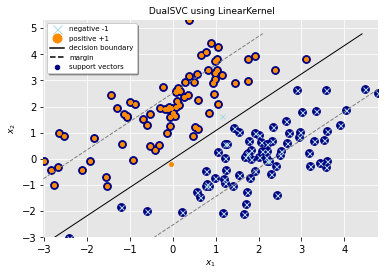

svc accuracy score is 0.98
svc found 148 support vectors from 150 examples
svc w is [-0.43047204  0.39660271]
svc b is 0.0036264139544315887


In [25]:
X, y = generate_linearly_separable_overlap_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svc = DualSVC(kernel=linear, C=0.1, optimizer=AdaGrad, verbose=True)
custom_time = %timeit -n1 -r1 -o svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
custom_accuracy = svc.score(X_test, y_test)
print(f'svc accuracy score is {custom_accuracy}')
custom_support_vectors = len(svc.support_)
print(f'svc found {custom_support_vectors} support vectors from {len(X_train)} examples')
print(f'svc w is {svc.coef_}')
print(f'svc b is {svc.intercept_}')

In [26]:
results['formulation'].append('lagrangian_dual')
results['loss'].append('hinge')
results['kernel'].append('linear')
results['implementation'].append('custom')
results['time'].append(custom_time.average)
results['score'].append(custom_accuracy)
results['support_vectors'].append(custom_support_vectors)

### Support Vector Regression

Instead of attempting to classify new unseen variables $x'$ into one of two categories $y'=\pm 1$, we now wish to predict a real-valued output for $y'$ so that our training data is of the form:

$$
\{x_i,y_i\} \text{where i}=1, \dots, n, x\in\Re^{m}, y_{i}\in\Re
$$

The regression SVM will use a more sophisticated penalty function than before, not allocating a penalty if the predicted value $y'_{i}$ is less than a distance $\epsilon$ away from the actual value $y_{i}$, i.e., if $|y_{i}-y'_{i}|<\epsilon$. 

<img src="./img/svr.png" width=600/>

Referring to this figure, the region bound by $y'_{i}\pm\epsilon \ \forall_{i}$ is called an $\epsilon$-insensitive tube. The other modification to the penalty function is that output variables which are outside the tube are given one of two slack variable penalties depending on whether they lie above $(\xi^{+})$ or below $(\xi^{-})$ the tube (where $\xi^{+} \geq 0, \xi^{-} \geq 0 \ \forall_{i}$):

$$
\begin{equation}
    y_{i}\leq y'_{i}+\epsilon+\xi^{+} \tag{3.1}
\end{equation}
$$
$$
\begin{equation}
    y_{i}\geq y'_{i}-\epsilon-\xi^{-} \tag{3.2}
\end{equation}
$$

The error function for SVM regression can then be written as:

$$
\begin{equation}
    \begin{aligned}
        \min_{w,b,\xi^{+},\xi^{-}} \quad & \frac{1}{2}\Vert w\Vert^{2} + C \sum_{i=1}^{n}(\xi_{i}^{+}+\xi_{i}^{-}) \\
            \textrm{subject to} \quad & y_{i} - \langle w, x_i \rangle - b \leq \epsilon + \xi_{i}^{+} \ \forall_{i} \\ & \langle w, x_i \rangle + b - y_{i} \leq \epsilon + \xi_{i}^{-} \ \forall_{i} \\ & \xi_{i}^{+}, \xi_{i}^{-} \geq 0 \ \forall_{i}
    \end{aligned} \tag{3.3}
\end{equation}
$$

which can be equivalently formulated as: 

$$
\begin{equation}
    \min_ {w, b} \frac{1}{2} \Vert w\Vert^{2} + C 
        \begin{cases}
            \sum_{i=1}^n \max(0, |y_i - (\langle w, x_i \rangle + b)| - \epsilon) & \text{if using L1 loss} \\
            \sum_{i=1}^n \max(0, |y_i - (\langle w, x_i \rangle + b)| - \epsilon)^2 & \text{if using L2 loss}
          \end{cases} \tag{3.4}
\end{equation}
$$

where we make use of the epsilon-insensitive (L1 loss) and squared epsilon-insensitive (L2 loss) loss respectively, i.e., errors of less than $\epsilon$ are ignored.

In [27]:
from optiml.ml.svm import PrimalSVR
from optiml.ml.svm.losses import epsilon_insensitive, squared_epsilon_insensitive
from optiml.ml.utils import plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad, StochasticGradientDescent
from optiml.opti.utils import plot_trajectory_optimization

from sklearn.svm import LinearSVR as SKLinearSVR
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

epoch	iter	 cost	
   0	   0	 5.0007e+01 - val_loss:  6.3635e+01 - r2: -0.0000
  50	  50	 3.8694e+01 - val_loss:  6.2742e+01 - r2:  0.4599
 100	 100	 3.4536e+01 - val_loss:  7.4235e+01 - r2:  0.6348
 150	 150	 3.2256e+01 - val_loss:  8.6488e+01 - r2:  0.7337
 200	 200	 3.0795e+01 - val_loss:  9.8406e+01 - r2:  0.7992
 250	 250	 2.9814e+01 - val_loss:  1.0968e+02 - r2:  0.8455
 300	 300	 2.9130e+01 - val_loss:  1.2019e+02 - r2:  0.8795
 350	 350	 2.8643e+01 - val_loss:  1.2993e+02 - r2:  0.9051
 400	 400	 2.8293e+01 - val_loss:  1.3889e+02 - r2:  0.9245
 450	 450	 2.8058e+01 - val_loss:  1.4710e+02 - r2:  0.9396
 500	 500	 2.7895e+01 - val_loss:  1.5461e+02 - r2:  0.9512
 550	 550	 2.7784e+01 - val_loss:  1.6144e+02 - r2:  0.9604
 600	 600	 2.7712e+01 - val_loss:  1.6766e+02 - r2:  0.9676
 650	 650	 2.7702e+01 - val_loss:  1.7329e+02 - r2:  0.9733
 700	 700	 2.7712e+01 - val_loss:  1.7840e+02 - r2:  0.9778
 750	 750	 2.7737e+01 - val_loss:  1.8309e+02 - r2:  0.9814
 800	 800	 2.7777e+01 

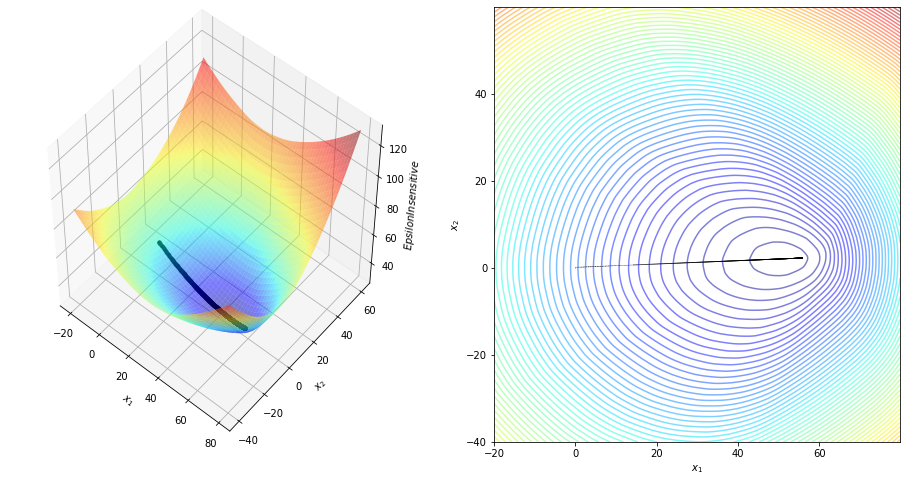

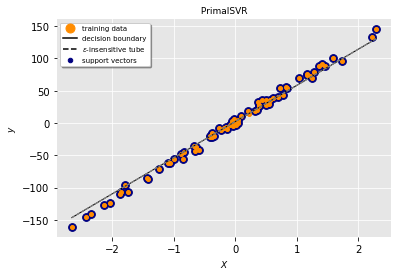

svr r2 score is 0.991484894503427
svr found 98 support vectors from 75 examples
svr w is [55.92688142]
svr b is 2.2644865247557857

719 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


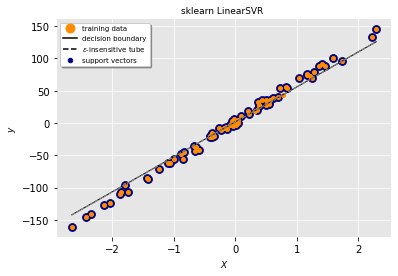

sklearn svr r2 score is 0.9866670121682691
sklearn svr found 96 support vectors from 75 examples
sklearn svr w is [54.10769956]
sklearn svr b is [1.68810279]


In [28]:
X, y = make_regression(n_samples=100, n_features=1, noise=4., bias=2., random_state=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svr = PrimalSVR(loss=epsilon_insensitive, epsilon=0.1, optimizer=AdaGrad, 
                learning_rate_init=0.15, momentum_type='nesterov', 
                early_stopping=False, validation_split=0.1, verbose=50)
custom_time = %timeit -n1 -r1 -o svr.fit(X_train, y_train)
plot_trajectory_optimization(svr.loss, svr.optimizer, -20, 80, -40, 60)
plot_svm_hyperplane(svr, X_train, y_train)
custom_r2 = svr.score(X_test, y_test)
print(f'svr r2 score is {custom_r2}')
custom_support_vectors = np.argwhere(np.abs(y - svr.predict(X)) >= svr.epsilon).ravel()
print(f'svr found {len(custom_support_vectors)} support vectors from {len(X_train)} examples')
print(f'svr w is {svr.coef_}')
print(f'svr b is {svr.intercept_}')

print()

svr = SKLinearSVR(loss='epsilon_insensitive', epsilon=0.1)
sklearn_time = %timeit -n1 -r1 -o svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
sklearn_r2 = svr.score(X_test, y_test)
print(f'sklearn svr r2 score is {sklearn_r2}')
sklearn_support_vectors = np.argwhere(np.abs(y - svr.predict(X)) >= svr.epsilon).ravel()
print(f'sklearn svr found {len(sklearn_support_vectors)} support vectors from {len(X_train)} examples')
print(f'sklearn svr w is {svr.coef_}')
print(f'sklearn svr b is {svr.intercept_}')

In [29]:
results['formulation'].append('primal')
results['loss'].append('epsilon_insensitive')
results['kernel'].append('linear')
results['implementation'].append('custom')
results['time'].append(custom_time.average)
results['score'].append(custom_r2)
results['support_vectors'].append(len(custom_support_vectors))

results['formulation'].append('primal')
results['loss'].append('epsilon_insensitive')
results['kernel'].append('linear')
results['implementation'].append('sklearn')
results['time'].append(sklearn_time.average)
results['score'].append(sklearn_r2)
results['support_vectors'].append(len(sklearn_support_vectors))

epoch	iter	 cost	
   0	   0	 3.9468e+03 - val_loss:  4.0605e+03 - r2: -0.0043
  50	  50	 4.0413e+01 - val_loss:  2.3738e+02 - r2:  0.9965
 100	 100	 4.0413e+01 - val_loss:  2.3738e+02 - r2:  0.9965
 150	 150	 4.0413e+01 - val_loss:  2.3738e+02 - r2:  0.9965
 200	 200	 4.0413e+01 - val_loss:  2.3738e+02 - r2:  0.9965
 250	 250	 4.0413e+01 - val_loss:  2.3738e+02 - r2:  0.9965
 300	 300	 4.0413e+01 - val_loss:  2.3738e+02 - r2:  0.9965
 350	 350	 4.0413e+01 - val_loss:  2.3738e+02 - r2:  0.9965
 400	 400	 4.0413e+01 - val_loss:  2.3738e+02 - r2:  0.9965
 450	 450	 4.0413e+01 - val_loss:  2.3738e+02 - r2:  0.9965
 500	 500	 4.0413e+01 - val_loss:  2.3738e+02 - r2:  0.9965
 550	 550	 4.0413e+01 - val_loss:  2.3738e+02 - r2:  0.9965
 600	 600	 4.0413e+01 - val_loss:  2.3738e+02 - r2:  0.9965
 650	 650	 4.0413e+01 - val_loss:  2.3738e+02 - r2:  0.9965
 700	 700	 4.0413e+01 - val_loss:  2.3738e+02 - r2:  0.9965
 750	 750	 4.0413e+01 - val_loss:  2.3738e+02 - r2:  0.9965
 800	 800	 4.0413e+01 

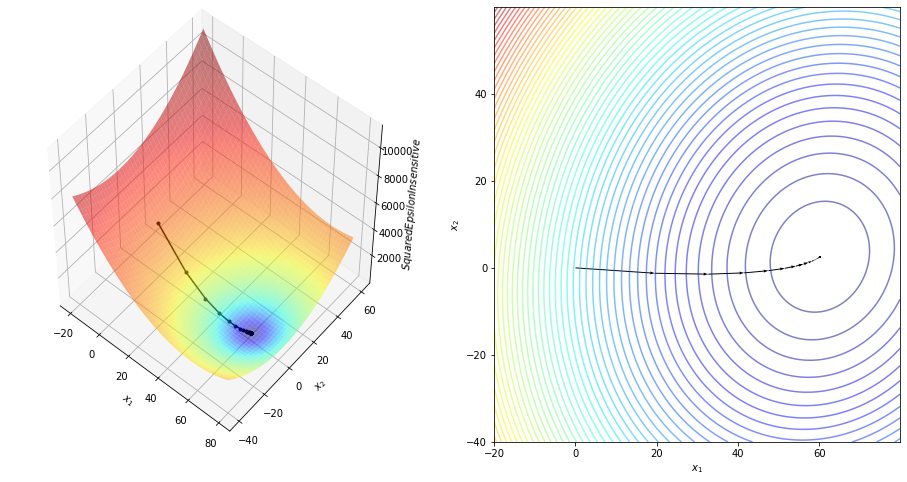

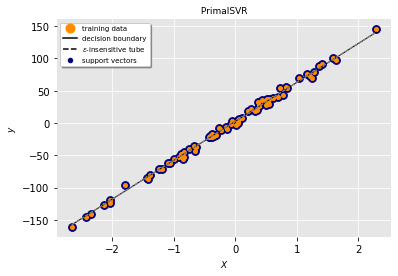

svr r2 score is 0.9958792368465459
svr found 100 support vectors from 75 examples
svr w is [60.17766048]
svr b is 2.564010593469361

704 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


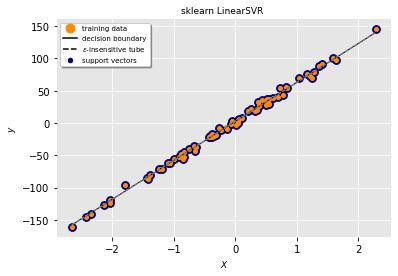

sklearn svr r2 score is 0.9959214631501166
sklearn svr found 98 support vectors from 75 examples
sklearn svr w is [60.25525609]
sklearn svr b is [2.4693605]


In [30]:
X, y = make_regression(n_samples=100, n_features=1, noise=4., bias=2., random_state=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svr = PrimalSVR(loss=squared_epsilon_insensitive, epsilon=0.1, 
                optimizer=StochasticGradientDescent, 
                learning_rate_init=0.15, early_stopping=False, 
                validation_split=0.1, verbose=50)
custom_time = %timeit -n1 -r1 -o svr.fit(X_train, y_train)
plot_trajectory_optimization(svr.loss, svr.optimizer, -20, 80, -40, 60)
plot_svm_hyperplane(svr, X_train, y_train)
custom_r2 = svr.score(X_test, y_test)
print(f'svr r2 score is {custom_r2}')
custom_support_vectors = np.argwhere(np.abs(y - svr.predict(X)) >= svr.epsilon).ravel()
print(f'svr found {len(custom_support_vectors)} support vectors from {len(X_train)} examples')
print(f'svr w is {svr.coef_}')
print(f'svr b is {svr.intercept_}')

print()

svr = SKLinearSVR(loss='squared_epsilon_insensitive', epsilon=0.1)
sklearn_time = %timeit -n1 -r1 -o svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
sklearn_r2 = svr.score(X_test, y_test)
print(f'sklearn svr r2 score is {sklearn_r2}')
sklearn_support_vectors = np.argwhere(np.abs(y - svr.predict(X)) >= svr.epsilon).ravel()
print(f'sklearn svr found {len(sklearn_support_vectors)} support vectors from {len(X_train)} examples')
print(f'sklearn svr w is {svr.coef_}')
print(f'sklearn svr b is {svr.intercept_}')

In [32]:
results['formulation'].append('primal')
results['loss'].append('squared_epsilon_insensitive')
results['kernel'].append('linear')
results['implementation'].append('custom')
results['time'].append(custom_time.average)
results['score'].append(custom_r2)
results['support_vectors'].append(len(custom_support_vectors))

results['formulation'].append('primal')
results['loss'].append('squared_epsilon_insensitive')
results['kernel'].append('linear')
results['implementation'].append('sklearn')
results['time'].append(sklearn_time.average)
results['score'].append(sklearn_r2)
results['support_vectors'].append(len(sklearn_support_vectors))

This needs to be minimized subject to the constraints $\xi^{+}\geq 0, \xi^{-}\geq 0 \ \forall_{i}$ and (3.1) and (3.2). In order to do this we introduce Lagrange multipliers $\alpha_{i}^{+}\geq 0, \alpha_{i}^{-}\geq 0, \mu_{i}^{+}\geq 0\mu_{i}^{-}\geq 0 \ \forall_{i}$:

$$
\begin{equation}
    \mathcal{W}(w,b,\xi^{+},\xi^{-}) \displaystyle = \frac{1}{2}\Vert w\Vert^{2}+C \sum_{i=1}^n(\xi_{i}^{+}+\xi_{i}^{-})-\sum_{i=1}^n(\mu_{i}^{+}\xi_{i}^{+}+\mu_{i}^{-}\xi_{i}^{-})-\sum_{i=1}^n\alpha_{i}^{+}(\epsilon+\xi_{i}^{+}+y'_{i}-y_{i})-\sum_{i=1}^n\alpha_{i}^{-}(\epsilon+\xi_{i}^{-}-y'_{i}+y_{i}) \tag{3.5}
\end{equation}
$$

Substituting for $y_{i}$, differentiating with respect to $w, b, \xi^{+}$ and $\xi^{-}$ and setting the derivatives to $0$:

$$
\begin{equation}
    \displaystyle \frac{\partial \mathcal{W}}{\partial w}=0\Rightarrow w=\sum_{i=1}^{n}(\alpha_{i}^{+}-\alpha_{i}^{-})x_{i} \tag{3.6}
\end{equation}
$$
$$
\begin{equation}
    \displaystyle \frac{\partial \mathcal{W}}{\partial b}=0\Rightarrow \sum_{i=1}^{n}(\alpha_{i}^{+}-\alpha_{i}^{-})=0 \tag{3.7}
\end{equation}
$$
$$
\begin{equation}
    \displaystyle \frac{\partial \mathcal{W}}{\partial\xi_{i}^{+}}=0\Rightarrow C=\alpha_{i}^{+}+\mu_{i}^{+} \tag{3.8}
\end{equation}
$$
$$
\begin{equation}
    \displaystyle \frac{\partial \mathcal{W}}{\partial\xi_{i}^{-}}=0\Rightarrow C=\alpha_{i}^{-}+\mu_{i}^{-} \tag{3.9}
\end{equation}
$$

Substituting (3.6) and (3.7) in, we now need to maximize $L_{D}$ with respect to $\alpha_{i}^{+}$ and $\alpha_{i}^{-}(\alpha_{i}^{+}\geq 0,\ \alpha_{i}^{-}\geq 0 \ \forall_{i})$ where:

$$
\begin{equation}
    \mathcal{W}(\alpha^{+},\alpha^{-}) = \displaystyle \sum_{i=1}^{n}y_{i}(\alpha_{i}^{+}-\alpha_{i}^{-})-\epsilon\sum_{i=1}^{n}(\alpha_{i}^{+}+\alpha_{i}^{-})-\frac{1}{2}\sum_{i,j}(\alpha_{i}^{+}-\alpha_{i}^{-})\langle x_i, x_j \rangle(\alpha_{j}^{+}-\alpha_{j}^{-}) \tag{3.10}
\end{equation}
$$

Using $\mu_{i}^{+}\geq 0$ and $\mu_{i}^{-}\geq 0$ together with (3.8) and (3.9) means that $\alpha_{i}^{+}\leq C$ and $\alpha_{i}^{-}\leq C$. We therefore need to find:

$$
\begin{equation}
    \begin{aligned}
        \min_{\alpha^+,\alpha^-} \quad & \frac{1}{2}(\alpha^{+}-\alpha^{-})^TQ(\alpha^{+}-\alpha^{-})+\epsilon q^T(\alpha^{+}+\alpha^{-})-y^T(\alpha^{+}-\alpha^{-}) \\
            \textrm{subject to} \quad & 0\leq\alpha_{i}^{+},\alpha_{i}^{-}\leq C \ \forall_{i} \\ & q^T(\alpha^{+}-\alpha^{-})=0
    \end{aligned} \tag{3.11}
\end{equation}
$$

where $q$ is a vector of all ones.

Each new predictions $y'$ can be found using:

$$
\begin{equation}
    y'=\displaystyle \sum_{i=1}^{n}(\alpha_{i}^{+}-\alpha_{i}^{-})\langle x_{i}, x' \rangle+b \tag{3.12}
\end{equation}
$$

A set $S$ of Support Vectors $x_{s}$ can be created by finding the indices $i$ where $0\leq\alpha\leq C$ and $\xi_{i}^{+}=0$ (or $\xi_{i}^{-}=0$).

This gives us:

$$
\begin{equation}
    b=y_{s}-\displaystyle \epsilon-\sum_{m\in S}(\alpha_m^+ -\alpha_m^-) \langle x_{m}, x_{s} \rangle \tag{3.13}
\end{equation}
$$

As before it is better to average over all the indices $i$ in $S$:

$$
\begin{equation}
    b=\displaystyle \frac{1}{N_{s}}\sum_{s\in S}y_{s}-\epsilon-\sum_{m\in S}(\alpha_{m}^{+}-\alpha_{m}^{-})\langle x_{m}, x_{s} \rangle \tag{3.14}
\end{equation}
$$

In [33]:
from optiml.ml.svm import DualSVR
from optiml.ml.svm.smo import SMORegression
from optiml.ml.svm.kernels import linear
from optiml.ml.utils import plot_svm_hyperplane

from sklearn.svm import SVR as SKLSVR
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

iter	 cost
   0	-1.8037e+03
   1	-1.8037e+03
   2	-1.8378e+03
   3	-1.8382e+03
   4	-1.8499e+03
   5	-1.8499e+03
   6	-1.8499e+03
   7	-1.8537e+03
   8	-1.8537e+03
   9	-1.8537e+03
  10	-1.8537e+03
  11	-1.8537e+03

49 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


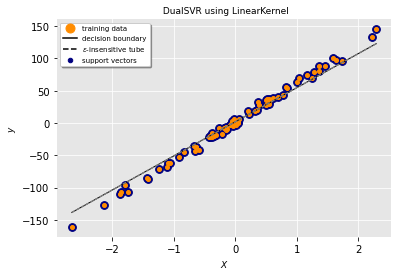

svr r2 score is 0.9768700126894633
svr found 74 support vectors from 75 examples
svr w is [52.74503253]
svr b is 1.8132658488356517

     pcost       dcost       gap    pres   dres
 0: -2.8940e+03 -2.5676e+03  8e+03  7e+00  3e-16
 1: -2.0568e+03 -2.4068e+03  1e+03  1e+00  2e-16
 2: -1.9156e+03 -2.1321e+03  5e+02  3e-01  2e-16
 3: -1.8687e+03 -2.0675e+03  4e+02  2e-01  2e-16
 4: -1.8456e+03 -1.9352e+03  1e+02  6e-02  2e-16
 5: -1.8511e+03 -1.8663e+03  2e+01  9e-03  1e-16
 6: -1.8540e+03 -1.8577e+03  5e+00  2e-03  1e-16
 7: -1.8551e+03 -1.8554e+03  4e-01  7e-05  2e-16
 8: -1.8552e+03 -1.8552e+03  1e-02  3e-06  2e-16
 9: -1.8552e+03 -1.8552e+03  1e-04  3e-08  2e-16
Optimal solution found.

34.6 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


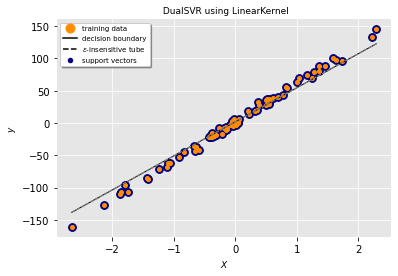

cvxopt svr r2 score is 0.9765200482948563
cvxopt svr found 75 support vectors from 75 examples
cvxopt svr w is [52.6703393]
cvxopt svr b is 1.7870331284474275

1.55 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


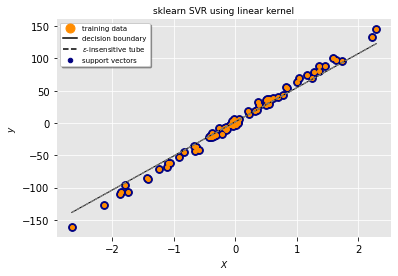

sklearn svr r2 score is 0.9768683857772666
sklearn svr found 74 support vectors from 75 examples
sklearn svr w is [[52.74503273]]
sklearn svr b is [1.81521453]


In [34]:
X, y = make_regression(n_samples=100, n_features=1, noise=4., bias=2., random_state=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svr = DualSVR(kernel=linear, epsilon=0.1, optimizer=SMORegression, verbose=True)
custom_time = %timeit -n1 -r1 -o svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
custom_r2 = svr.score(X_test, y_test)
print(f'svr r2 score is {custom_r2}')
custom_support_vectors = len(svr.support_)
print(f'svr found {custom_support_vectors} support vectors from {len(X_train)} examples')
print(f'svr w is {svr.coef_}')
print(f'svr b is {svr.intercept_}')

print()

svr = DualSVR(kernel=linear, epsilon=0.1, optimizer='cvxopt', verbose=True)
cvxopt_time = %timeit -n1 -r1 -o svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
cvxopt_r2 = svr.score(X_test, y_test)
print(f'cvxopt svr r2 score is {cvxopt_r2}')
cvxopt_support_vectors = len(svr.support_)
print(f'cvxopt svr found {cvxopt_support_vectors} support vectors from {len(X_train)} examples')
print(f'cvxopt svr w is {svr.coef_}')
print(f'cvxopt svr b is {svr.intercept_}')

print()

svr = SKLSVR(kernel='linear', epsilon=0.1)
sklearn_time = %timeit -n1 -r1 -o svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
sklearn_r2 = svr.score(X_test, y_test)
print(f'sklearn svr r2 score is {sklearn_r2}')
sklearn_support_vectors = len(svr.support_)
print(f'sklearn svr found {sklearn_support_vectors} support vectors from {len(X_train)} examples')
print(f'sklearn svr w is {svr.coef_}')
print(f'sklearn svr b is {svr.intercept_}')

In [35]:
results['formulation'].append('wolfe_dual')
results['loss'].append('epsilon_insensitive')
results['kernel'].append('linear')
results['implementation'].append('custom')
results['time'].append(custom_time.average)
results['score'].append(custom_r2)
results['support_vectors'].append(custom_support_vectors)

results['formulation'].append('wolfe_dual')
results['loss'].append('epsilon_insensitive')
results['kernel'].append('linear')
results['implementation'].append('cvxopt')
results['time'].append(cvxopt_time.average)
results['score'].append(cvxopt_r2)
results['support_vectors'].append(cvxopt_support_vectors)

results['formulation'].append('wolfe_dual')
results['loss'].append('epsilon_insensitive')
results['kernel'].append('linear')
results['implementation'].append('sklearn')
results['time'].append(sklearn_time.average)
results['score'].append(sklearn_r2)
results['support_vectors'].append(sklearn_support_vectors)

The solution of the *Lagrangian dual* relaxation according to (1.20) is: 

In [36]:
from optiml.ml.svm import DualSVR
from optiml.ml.svm.kernels import linear
from optiml.ml.utils import plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

epoch	iter	 cost	
   0	   0	-1.8348e+03	ub: -1.8348e+03 - pcost:  1.8348e+03 - gap:  2.0000e+00
   1	   1	-1.8153e+03	ub:  1.8348e+03 - pcost:  1.8348e+03 - gap:  0.0000e+00

39.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


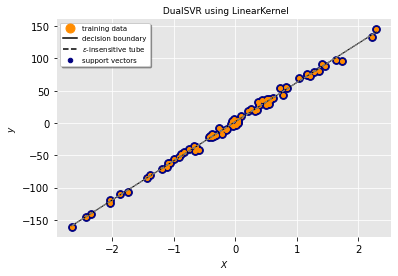

svr r2 score is 0.995867296077572
svr found 74 support vectors from 75 examples
svr w is [60.54305203]
svr b is 2.0174518186504855


In [37]:
X, y = make_regression(n_samples=100, n_features=1, noise=4., bias=2., random_state=2)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svr = DualSVR(kernel=linear, epsilon=0.1, optimizer=AdaGrad, verbose=True)
custom_time = %timeit -n1 -r1 -o svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
custom_r2 = svr.score(X_test, y_test)
print(f'svr r2 score is {custom_r2}')
custom_support_vectors = len(svr.support_)
print(f'svr found {sklearn_support_vectors} support vectors from {len(X_train)} examples')
print(f'svr w is {svr.coef_}')
print(f'svr b is {svr.intercept_}')

In [38]:
results['formulation'].append('lagrangian_dual')
results['loss'].append('epsilon_insensitive')
results['kernel'].append('linear')
results['implementation'].append('custom')
results['time'].append(custom_time.average)
results['score'].append(custom_r2)
results['support_vectors'].append(custom_support_vectors)

### Nonlinear Support Vector Machines

When applying our SVM to linearly separable data we have started by creating a matrix $Q$ from the dot product of our input variables:

$$ Q_{ij}=y_{i}y_{j}k(x_{i},\ x_{j})= \langle x_{i}, x_{j} \rangle=x_{i}^{T}x_{j} $$

$k(x_{i},x_{j})$ is an example of a family of functions called *kernel functions* where $k(x_{i},x_{j})=\langle x_{i}, x_{j} \rangle$ being known as a *linear* kernel. The set of kernel functions is composed of variants of (3.1) in that they are all based on calculating inner products of two vectors. This means that if the functions can be recast into a higher dimensionality space by some potentially nonlinear feature mapping function $x\rightarrow \phi(x)$, only inner products of the mapped inputs in the feature space need be determined without us needing to explicitly calculate $\phi$.

The reason that this *kernel trick* is useful is that there are many classification/regression problems that are not linearly separable/regressable in the space of the inputs $x$, which might be in a higher dimensionality feature space given a suitable mapping $x \rightarrow \phi(x)$.

#### Polynomial Kernel

The *polynomial* kernel is defined as:

$$k(x_{i},x_{j})=(\gamma \langle x_i, x_j\rangle + r)^d$$

where $\gamma$ define how far the influence of a single training example reaches (low values meaning ‘far’ and high values meaning ‘close’) and is specified by keyword *gamma*, $d$ by *degree* and $r$ by *coef0*.

##### Support Vector Classifier

In [40]:
from optiml.ml.svm import DualSVC
from optiml.ml.svm.smo import SMOClassifier
from optiml.ml.svm.kernels import PolyKernel
from optiml.ml.utils import generate_non_linearly_separable_data, plot_svm_hyperplane

from sklearn.svm import SVC as SKLSVC
from sklearn.model_selection import train_test_split

iter	 cost
   0	-3.8385e-02
   5	-4.7802e-02
  10	-4.8730e-02
  15	-4.8798e-02
  20	-4.8816e-02
  25	-4.8825e-02
  30	-4.8827e-02
  35	-4.8828e-02
  40	-4.9425e-02
  45	-4.9654e-02
  50	-4.9663e-02
  55	-4.9670e-02
  60	-4.9676e-02
  65	-4.9682e-02
  70	-4.9687e-02
  75	-4.9691e-02
  80	-4.9693e-02

544 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


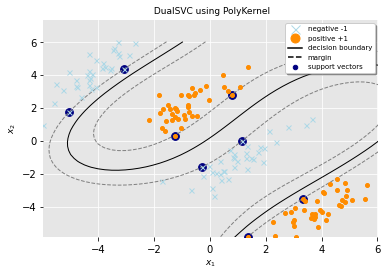

svc accuracy score is 1.0
svc found 8 support vectors from 150 examples
svc b is -0.12419812996641086

     pcost       dcost       gap    pres   dres
 0: -3.1981e+01 -3.4299e+02  2e+03  3e+00  6e-12
 1: -1.7550e+01 -2.0336e+02  4e+02  4e-01  4e-12
 2: -6.7339e+00 -7.1536e+01  1e+02  1e-01  3e-12
 3: -2.0902e+00 -2.3533e+01  4e+01  4e-02  1e-12
 4: -3.3197e-02 -4.3605e+00  6e+00  5e-03  5e-13
 5:  3.7408e-02 -6.2847e-01  9e-01  5e-04  5e-14
 6: -5.7729e-03 -1.9990e-01  2e-01  1e-04  1e-14
 7: -2.7803e-02 -9.8024e-02  7e-02  1e-05  2e-15
 8: -3.7857e-02 -7.7617e-02  4e-02  2e-06  2e-15
 9: -4.5597e-02 -5.7717e-02  1e-02  7e-07  2e-15
10: -4.8652e-02 -5.1720e-02  3e-03  2e-16  2e-15
11: -4.9702e-02 -5.0193e-02  5e-04  1e-16  2e-15
12: -4.9875e-02 -4.9948e-02  7e-05  2e-16  2e-15
13: -4.9904e-02 -4.9906e-02  1e-06  2e-16  2e-15
14: -4.9905e-02 -4.9905e-02  2e-08  2e-16  2e-15
Optimal solution found.

42.6 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


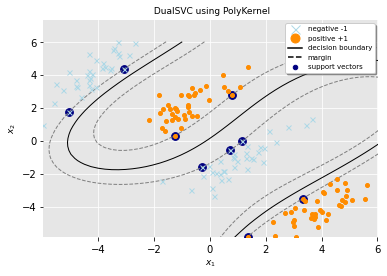

cvxopt svc accuracy score is 1.0
cvxopt svc found 9 support vectors from 150 examples
cvxopt svc b is 1.51699841190024e-06

1.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


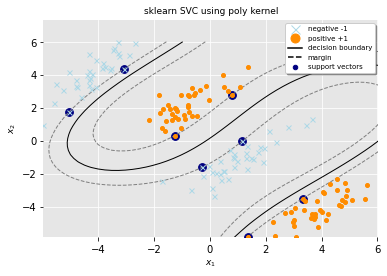

sklearn svc accuracy score is 1.0
sklearn svc found 8 support vectors from 150 examples
sklearn svc b is [-0.11006095]


In [42]:
X, y = generate_non_linearly_separable_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svc = DualSVC(kernel=PolyKernel(degree=3, coef0=3, gamma='auto'), optimizer=SMOClassifier, verbose=5)
custom_time = %timeit -n1 -r1 -o svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
custom_accuracy = svc.score(X_test, y_test)
print(f'svc accuracy score is {custom_accuracy}')
custom_support_vectors = len(svc.support_)
print(f'svc found {custom_support_vectors} support vectors from {len(X_train)} examples')
print(f'svc b is {svc.intercept_}')

print()

svc = DualSVC(kernel=PolyKernel(degree=3, coef0=3, gamma='auto'), optimizer='cvxopt', verbose=True)
cvxopt_time = %timeit -n1 -r1 -o svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
cvxopt_accuracy = svc.score(X_test, y_test)
print(f'cvxopt svc accuracy score is {cvxopt_accuracy}')
cvxopt_support_vectors = len(svc.support_)
print(f'cvxopt svc found {cvxopt_support_vectors} support vectors from {len(X_train)} examples')
print(f'cvxopt svc b is {svc.intercept_}')

print()

svc = SKLSVC(kernel='poly', degree=3, coef0=3, gamma='auto')
sklearn_time = %timeit -n1 -r1 -o svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
sklearn_accuracy = svc.score(X_test, y_test)
print(f'sklearn svc accuracy score is {sklearn_accuracy}')
sklearn_support_vectors = len(svc.support_)
print(f'sklearn svc found {sklearn_support_vectors} support vectors from {len(X_train)} examples')
print(f'sklearn svc b is {svc.intercept_}')

In [43]:
results['formulation'].append('wolfe_dual')
results['loss'].append('hinge')
results['kernel'].append('polynomial')
results['implementation'].append('custom')
results['time'].append(custom_time.average)
results['score'].append(custom_accuracy)
results['support_vectors'].append(custom_support_vectors)

results['formulation'].append('wolfe_dual')
results['loss'].append('hinge')
results['kernel'].append('polynomial')
results['implementation'].append('cvxopt')
results['time'].append(cvxopt_time.average)
results['score'].append(cvxopt_accuracy)
results['support_vectors'].append(cvxopt_support_vectors)

results['formulation'].append('wolfe_dual')
results['loss'].append('hinge')
results['kernel'].append('polynomial')
results['implementation'].append('sklearn')
results['time'].append(sklearn_time.average)
results['score'].append(sklearn_accuracy)
results['support_vectors'].append(sklearn_support_vectors)

The solution of the *Lagrangian dual* relaxation according to (1.20) is: 

In [44]:
from optiml.ml.svm import DualSVC
from optiml.ml.svm.kernels import PolyKernel
from optiml.ml.utils import generate_non_linearly_separable_data, plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.model_selection import train_test_split

epoch	iter	 cost	
   0	   0	-9.6531e-03	ub: -9.6531e-03 - pcost:  9.6531e-03 - gap:  1.9306e-02
   1	   1	 1.4988e+01	ub:  9.6531e-03 - pcost:  9.6531e-03 - gap:  0.0000e+00

49.9 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


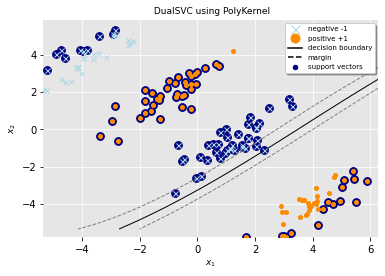

svc accuracy score is 0.78
svc found 105 support vectors from 150 examples
svc b is -1.9531325032465814


In [45]:
X, y = generate_non_linearly_separable_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svc = DualSVC(kernel=PolyKernel(degree=3, coef0=3, gamma='auto'), optimizer=AdaGrad, verbose=True)
custom_time = %timeit -n1 -r1 -o svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
custom_accuracy = svc.score(X_test, y_test)
print(f'svc accuracy score is {custom_accuracy}')
custom_support_vectors = len(svc.support_)
print(f'svc found {custom_support_vectors} support vectors from {len(X_train)} examples')
print(f'svc b is {svc.intercept_}')

In [46]:
results['formulation'].append('lagrangian_dual')
results['loss'].append('hinge')
results['kernel'].append('polynomial')
results['implementation'].append('custom')
results['time'].append(custom_time.average)
results['score'].append(custom_accuracy)
results['support_vectors'].append(custom_support_vectors)

##### Support Vector Regression

In [47]:
from optiml.ml.svm import DualSVR
from optiml.ml.svm.smo import SMORegression
from optiml.ml.svm.kernels import PolyKernel
from optiml.ml.utils import generate_non_linearly_regression_data, plot_svm_hyperplane

from sklearn.svm import SVR as SKLSVR
from sklearn.model_selection import train_test_split

In [ ]:
X, y = generate_non_linearly_regression_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svr = DualSVR(kernel=PolyKernel(degree=8, coef0=3, gamma='scale'), 
              epsilon=0.1, optimizer=SMORegression, verbose=False)
custom_time = %timeit -n1 -r1 -o svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
custom_r2 = svr.score(X_test, y_test)
print(f'svr r2 score is {custom_r2}')
custom_support_vectors = len(svr.support_)
print(f'svr found {custom_support_vectors} support vectors from {len(X_train)} examples')
print(f'svr b is {svr.intercept_}')

print()

svr = DualSVR(kernel=PolyKernel(degree=8, coef0=3, gamma='scale'), 
              epsilon=0.1, optimizer='cvxopt', verbose=True)
cvxopt_time = %timeit -n1 -r1 -o svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
cvxopt_r2 = svr.score(X_test, y_test)
print(f'cvxopt svr r2 score is {cvxopt_r2}')
cvxopt_support_vectors = len(svr.support_)
print(f'cvxopt svr found {cvxopt_support_vectors} support vectors from {len(X_train)} examples')
print(f'cvxopt svr b is {svr.intercept_}')

print()

svr = SKLSVR(kernel='poly', degree=8, coef0=3, gamma='scale', epsilon=0.1)
sklearn_time = %timeit -n1 -r1 -o svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
sklearn_r2 = svr.score(X_test, y_test)
print(f'sklearn svr r2 score is {sklearn_r2}')
sklearn_support_vectors = len(svr.support_)
print(f'sklearn svr found {sklearn_support_vectors} support vectors from {len(X_train)} examples')
print(f'sklearn svr b is {svr.intercept_}')

In [ ]:
results['formulation'].append('wolfe_dual')
results['loss'].append('epsilon_insensitive')
results['kernel'].append('polynomial')
results['implementation'].append('custom')
results['time'].append(custom_time.average)
results['score'].append(custom_accuracy)
results['support_vectors'].append(custom_support_vectors)

results['formulation'].append('wolfe_dual')
results['loss'].append('epsilon_insensitive')
results['kernel'].append('polynomial')
results['implementation'].append('cvxopt')
results['time'].append(cvxopt_time.average)
results['score'].append(cvxopt_accuracy)
results['support_vectors'].append(cvxopt_support_vectors)

results['formulation'].append('wolfe_dual')
results['loss'].append('epsilon_insensitive')
results['kernel'].append('polynomial')
results['implementation'].append('sklearn')
results['time'].append(sklearn_time.average)
results['score'].append(sklearn_accuracy)
results['support_vectors'].append(sklearn_support_vectors)

The solution of the *Lagrangian dual* relaxation according to (1.20) is: 

In [48]:
from optiml.ml.svm import DualSVR
from optiml.ml.svm.kernels import PolyKernel
from optiml.ml.utils import generate_non_linearly_regression_data, plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.model_selection import train_test_split

epoch	iter	 cost	
   0	   0	-9.7221e-03	ub: -9.7221e-03 - pcost:  9.7221e-03 - gap:  1.9444e-02
   1	   1	 1.4992e+01	ub:  9.7221e-03 - pcost:  9.7221e-03 - gap:  0.0000e+00

43.4 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


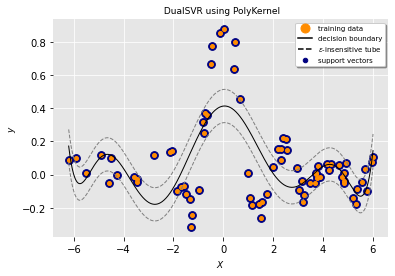

svr r2 score is 0.4662820830820146
svr found 75 support vectors from 75 examples
svr b is -0.0012702694800166433


In [54]:
X, y = generate_non_linearly_regression_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svr = DualSVR(kernel=PolyKernel(degree=8, coef0=3, gamma='scale'), 
              epsilon=0.1, optimizer=AdaGrad, verbose=True)
custom_time = %timeit -n1 -r1 -o svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
custom_r2 = svr.score(X_test, y_test)
print(f'svr r2 score is {custom_r2}')
custom_support_vectors = len(svr.support_)
print(f'svr found {custom_support_vectors} support vectors from {len(X_train)} examples')
print(f'svr b is {svr.intercept_}')

In [55]:
results['formulation'].append('lagrangian_dual')
results['loss'].append('epsilon_insensitive')
results['kernel'].append('polynomial')
results['implementation'].append('custom')
results['time'].append(custom_time.average)
results['score'].append(custom_r2)
results['support_vectors'].append(custom_support_vectors)

#### Gaussian RBF Kernel

The *gaussian* kernel is defined as:

$$k(x_{i},x_{j})=\exp(-\frac{\|x_i-x_j\|_2^2}{2\sigma^2})$$

or, equivalently, as:

$$k(x_{i},x_{j})=\exp(-\gamma \|x_i-x_j\|_2^2)$$

where $\displaystyle \gamma=\frac{1}{2\sigma^2}$ define how far the influence of a single training example reaches (low values meaning ‘far’ and high values meaning ‘close’) and is specified by keyword *gamma*.

##### Support Vector Classifier

In [56]:
from optiml.ml.svm import DualSVC
from optiml.ml.svm.smo import SMOClassifier
from optiml.ml.svm.kernels import GaussianKernel
from optiml.ml.utils import generate_non_linearly_separable_data, plot_svm_hyperplane

from sklearn.svm import SVC as SKLSVC
from sklearn.model_selection import train_test_split

iter	 cost
   0	-7.1200e+00
   1	-7.7585e+00
   2	-7.8689e+00
   3	-7.8909e+00
   4	-7.8931e+00
   5	-7.8940e+00
   6	-7.8945e+00
   7	-7.8949e+00
   8	-7.8950e+00
   9	-7.8951e+00
  10	-8.1414e+00
  11	-8.1994e+00
  12	-8.2056e+00
  13	-8.2062e+00
  14	-8.2063e+00
  15	-8.2063e+00

887 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


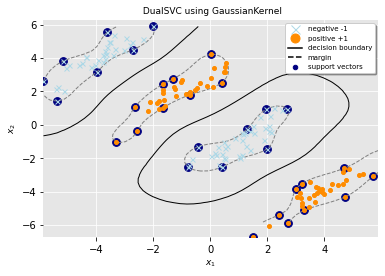

svc accuracy score is 1.0
svc found 33 support vectors from 150 examples
svc b is 0.062273918477408555

     pcost       dcost       gap    pres   dres
 0: -4.9068e+00 -1.8483e+02  2e+02  3e-17  4e-16
 1: -7.0435e+00 -1.7024e+01  1e+01  2e-16  5e-16
 2: -7.7021e+00 -9.9598e+00  2e+00  2e-16  2e-16
 3: -8.0939e+00 -8.5939e+00  5e-01  2e-16  2e-16
 4: -8.1888e+00 -8.3462e+00  2e-01  2e-16  2e-16
 5: -8.2325e+00 -8.2392e+00  7e-03  2e-16  2e-16
 6: -8.2350e+00 -8.2351e+00  1e-04  2e-16  2e-16
 7: -8.2351e+00 -8.2351e+00  2e-06  2e-16  2e-16
Optimal solution found.

51 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


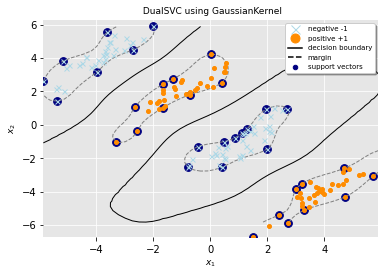

cvxopt svc accuracy score is 1.0
cvxopt svc found 36 support vectors from 150 examples
cvxopt svc b is 0.0004252742028965701

1.14 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


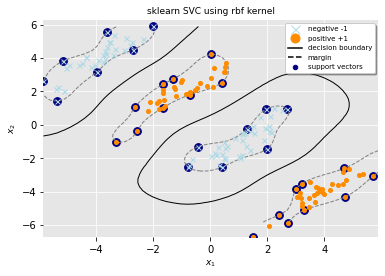

sklearn svc accuracy score is 1.0
sklearn svc found 33 support vectors from 150 examples
sklearn svc b is [0.06045307]


In [57]:
X, y = generate_non_linearly_separable_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svc = DualSVC(kernel=GaussianKernel(gamma='auto'), optimizer=SMOClassifier, verbose=True)
custom_time = %timeit -n1 -r1 -o svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
custom_accuracy = svc.score(X_test, y_test)
print(f'svc accuracy score is {custom_accuracy}')
custom_support_vectors = len(svc.support_)
print(f'svc found {custom_support_vectors} support vectors from {len(X_train)} examples')
print(f'svc b is {svc.intercept_}')

print()

svc = DualSVC(kernel=GaussianKernel(gamma='auto'), optimizer='cvxopt', verbose=True)
cvxopt_time = %timeit -n1 -r1 -o svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
cvxopt_accuracy = svc.score(X_test, y_test)
print(f'cvxopt svc accuracy score is {cvxopt_accuracy}')
cvxopt_support_vectors = len(svc.support_)
print(f'cvxopt svc found {cvxopt_support_vectors} support vectors from {len(X_train)} examples')
print(f'cvxopt svc b is {svc.intercept_}')

print()

svc = SKLSVC(kernel='rbf', gamma='auto')
sklearn_time = %timeit -n1 -r1 -o svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
sklearn_accuracy = svc.score(X_test, y_test)
print(f'sklearn svc accuracy score is {sklearn_accuracy}')
sklearn_support_vectors = len(svc.support_)
print(f'sklearn svc found {sklearn_support_vectors} support vectors from {len(X_train)} examples')
print(f'sklearn svc b is {svc.intercept_}')

In [58]:
results['formulation'].append('wolfe_dual')
results['loss'].append('hinge')
results['kernel'].append('gaussian')
results['implementation'].append('custom')
results['time'].append(custom_time.average)
results['score'].append(custom_accuracy)
results['support_vectors'].append(custom_support_vectors)

results['formulation'].append('wolfe_dual')
results['loss'].append('hinge')
results['kernel'].append('gaussian')
results['implementation'].append('cvxopt')
results['time'].append(cvxopt_time.average)
results['score'].append(cvxopt_accuracy)
results['support_vectors'].append(cvxopt_support_vectors)

results['formulation'].append('wolfe_dual')
results['loss'].append('hinge')
results['kernel'].append('gaussian')
results['implementation'].append('sklearn')
results['time'].append(sklearn_time.average)
results['score'].append(sklearn_accuracy)
results['support_vectors'].append(sklearn_support_vectors)

The solution of the *Lagrangian dual* relaxation according to (1.20) is: 

In [59]:
from optiml.ml.svm import DualSVC
from optiml.ml.svm.kernels import GaussianKernel
from optiml.ml.utils import generate_non_linearly_separable_data, plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.model_selection import train_test_split

epoch	iter	 cost	
   0	   0	-1.2679e+02	ub: -1.2679e+02 - pcost:  1.2679e+02 - gap:  2.0000e+00
   1	   1	 5.9759e+04	ub:  1.2679e+02 - pcost:  1.2679e+02 - gap:  0.0000e+00

415 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


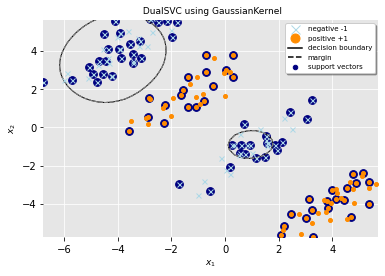

svc accuracy score is 0.76
svc found 80 support vectors from 150 examples
svc b is 15177.724439499047


In [60]:
X, y = generate_non_linearly_separable_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svc = DualSVC(kernel=GaussianKernel(gamma='auto'), optimizer=AdaGrad, verbose=True)
sklearn_time = %timeit -n1 -r1 -o svc.fit(X_train, y_train)
plot_svm_hyperplane(svc, X_train, y_train)
custom_accuracy = svc.score(X_test, y_test)
print(f'svc accuracy score is {custom_accuracy}')
custom_support_vectors = len(svc.support_)
print(f'svc found {custom_support_vectors} support vectors from {len(X_train)} examples')
print(f'svc b is {svc.intercept_}')

In [61]:
results['formulation'].append('lagrangian_dual')
results['loss'].append('hinge')
results['kernel'].append('gaussian')
results['implementation'].append('custom')
results['time'].append(custom_time.average)
results['score'].append(custom_accuracy)
results['support_vectors'].append(custom_support_vectors)

##### Support Vector Regression

In [62]:
from optiml.ml.svm import DualSVR
from optiml.ml.svm.smo import SMORegression
from optiml.ml.svm.kernels import GaussianKernel
from optiml.ml.utils import generate_non_linearly_regression_data, plot_svm_hyperplane

from sklearn.svm import SVR as SKLSVR
from sklearn.model_selection import train_test_split

iter	 cost
   0	-4.3607e-01
   2	-5.6604e-01
   4	-5.9675e-01
   6	-6.1836e-01
   8	-6.3366e-01
  10	-6.6871e-01
  12	-6.7994e-01
  14	-6.8270e-01
  16	-6.8312e-01
  18	-6.8320e-01
  20	-6.8444e-01
  22	-6.8644e-01
  24	-6.8824e-01
  26	-6.8865e-01
  28	-6.8890e-01
  30	-6.8898e-01
  32	-6.8912e-01
  34	-6.8994e-01
  36	-6.9037e-01
  38	-6.9044e-01
  40	-6.9044e-01

326 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


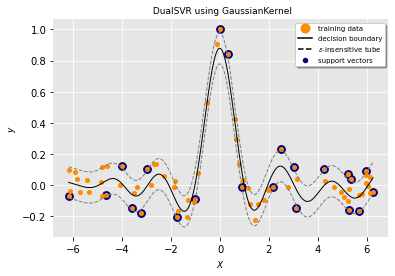

svr r2 score is 0.8992382580137264
svr found 22 support vectors from 75 examples
svr b is 0.06495982237243471

     pcost       dcost       gap    pres   dres
 0:  5.8041e+00 -1.7384e+02  2e+02  4e-17  2e-14
 1:  4.9443e+00 -7.8618e+00  1e+01  1e-16  2e-14
 2:  4.6840e-01 -1.8736e+00  2e+00  2e-16  2e-14
 3: -4.2554e-01 -9.5616e-01  5e-01  2e-16  8e-15
 4: -6.3271e-01 -7.5296e-01  1e-01  2e-16  6e-15
 5: -6.8533e-01 -7.0129e-01  2e-02  2e-16  5e-15
 6: -6.9209e-01 -6.9421e-01  2e-03  2e-16  5e-15
 7: -6.9308e-01 -6.9314e-01  6e-05  2e-16  5e-15
 8: -6.9311e-01 -6.9311e-01  7e-07  2e-16  5e-15
 9: -6.9311e-01 -6.9311e-01  7e-09  2e-16  5e-15
Optimal solution found.

51.6 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


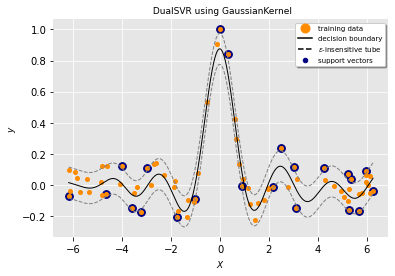

cvxopt svr r2 score is 0.8983440893343397
cvxopt svr found 22 support vectors from 75 examples
cvxopt svr b is 0.05270234609409316

1.49 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


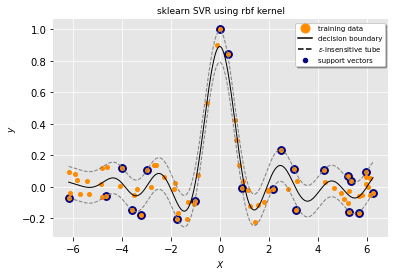

sklearn svr r2 score is 0.8986791546214297
sklearn svr found 22 support vectors from 75 examples
sklearn svr b is [0.07720997]


In [65]:
X, y = generate_non_linearly_regression_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svr = DualSVR(kernel=GaussianKernel(gamma='auto'), 
              epsilon=0.1, optimizer=SMORegression, verbose=2)
custom_time = %timeit -n1 -r1 -o svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
custom_r2 = svr.score(X_test, y_test)
print(f'svr r2 score is {custom_r2}')
custom_support_vectors = len(svr.support_)
print(f'svr found {custom_support_vectors} support vectors from {len(X_train)} examples')
print(f'svr b is {svr.intercept_}')

print()

svr = DualSVR(kernel=GaussianKernel(gamma='auto'), 
              epsilon=0.1, optimizer='cvxopt', verbose=True)
cvxopt_time = %timeit -n1 -r1 -o svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
cvxopt_r2 = svr.score(X_test, y_test)
print(f'cvxopt svr r2 score is {cvxopt_r2}')
cvxopt_support_vectors = len(svr.support_)
print(f'cvxopt svr found {cvxopt_support_vectors} support vectors from {len(X_train)} examples')
print(f'cvxopt svr b is {svr.intercept_}')

print()

svr = SKLSVR(kernel='rbf', gamma='auto')
sklearn_time = %timeit -n1 -r1 -o svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
sklearn_r2 = svr.score(X_test, y_test)
print(f'sklearn svr r2 score is {sklearn_r2}')
sklearn_support_vectors = len(svr.support_)
print(f'sklearn svr found {sklearn_support_vectors} support vectors from {len(X_train)} examples')
print(f'sklearn svr b is {svr.intercept_}')

In [66]:
results['formulation'].append('wolfe_dual')
results['loss'].append('epsilon_insensitive')
results['kernel'].append('gaussian')
results['implementation'].append('custom')
results['time'].append(custom_time.average)
results['score'].append(custom_r2)
results['support_vectors'].append(custom_support_vectors)

results['formulation'].append('wolfe_dual')
results['loss'].append('epsilon_insensitive')
results['kernel'].append('gaussian')
results['implementation'].append('cvxopt')
results['time'].append(cvxopt_time.average)
results['score'].append(cvxopt_r2)
results['support_vectors'].append(cvxopt_support_vectors)

results['formulation'].append('wolfe_dual')
results['loss'].append('epsilon_insensitive')
results['kernel'].append('gaussian')
results['implementation'].append('sklearn')
results['time'].append(sklearn_time.average)
results['score'].append(sklearn_r2)
results['support_vectors'].append(sklearn_support_vectors)

The solution of the *Lagrangian dual* relaxation according to (1.20) is: 

In [67]:
from optiml.ml.svm import DualSVR
from optiml.ml.svm.kernels import GaussianKernel
from optiml.ml.utils import generate_non_linearly_regression_data, plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.model_selection import train_test_split

epoch	iter	 cost	
   0	   0	-4.5724e+01	ub: -4.5724e+01 - pcost:  4.5724e+01 - gap:  2.0000e+00
   1	   1	 6.4246e+02	ub:  4.5724e+01 - pcost:  4.5724e+01 - gap:  0.0000e+00

250 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


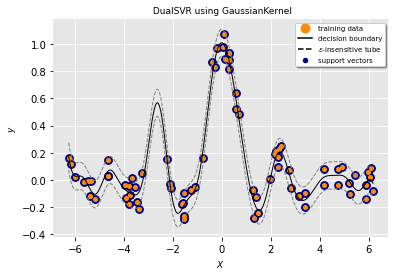

svr r2 score is 0.9138393165078719
svr found 75 support vectors from 75 examples
svr b is 0.1162876634215331


In [68]:
X, y = generate_non_linearly_regression_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75)

svr = DualSVR(kernel=GaussianKernel(gamma='auto'), optimizer=AdaGrad, verbose=True)
custom_time = %timeit -n1 -r1 -o svr.fit(X_train, y_train)
plot_svm_hyperplane(svr, X_train, y_train)
custom_r2 = svr.score(X_test, y_test)
print(f'svr r2 score is {custom_r2}')
custom_support_vectors = len(svr.support_)
print(f'svr found {custom_support_vectors} support vectors from {len(X_train)} examples')
print(f'svr b is {svr.intercept_}')

In [69]:
results['formulation'].append('lagrangian_dual')
results['loss'].append('epsilon_insensitive')
results['kernel'].append('gaussian')
results['implementation'].append('custom')
results['time'].append(custom_time.average)
results['score'].append(custom_r2)
results['support_vectors'].append(custom_support_vectors)

## Conclusions

From all these experiments whose results have been collected in the following table we can see that cvxopt significaively underperform all the other implementations in term of time since it is a general purpose QP solver and it doesn't not exploit the structure of the problem. In the field of numerical optimization it is known that if you want a better performance you should use a better model, so ad-hoc implementation are welcome. 
Oh the other hand sklearn provides the better results in terms of time wrt the other implementations since it is designed to work with the specific lasge scale svm model and it's core is implementend in C.
For what about the svm formulations, summarized in primal, wolfe and lagrangian dual, it is known, in general, that the primal formulation, is suitable for large linear training since the complexity of the model grows with the number of features or, more in general, when the number of examples $n$ is much larger than the number of features $m$, $n \gt\gt m$; while the last one, the dual formulation, is more suitable in case the number of examples $n$ is less than the number of features $m$, $n \lt m$, since the complexity of the model is dominated by the number of examples.

An import considerations involves the number of support vector machines which controls the complexity of the model in terms of overfitting and underfitting. The lagrangian dual formulation tends to select all the data points as support vectors, so it is makes the model unable to generalize. In fact the scores are significatively lower wrt the equivalent wolfe dual formulation.

In [70]:
import pandas as pd

df = pd.DataFrame(results)
df.style.hide_index()

formulation,loss,kernel,implementation,time,score,support_vectors
primal,hinge,linear,custom,1.163886,1.000000,7
primal,hinge,linear,sklearn,0.001208,1.000000,6
primal,squared_hinge,linear,custom,1.058612,1.000000,2
primal,squared_hinge,linear,sklearn,0.000945,1.000000,7
wolfe_dual,hinge,linear,custom,0.065430,1.000000,5
wolfe_dual,hinge,linear,cvxopt,0.044885,1.000000,4
wolfe_dual,hinge,linear,sklearn,0.001020,1.000000,5
lagrangian_dual,hinge,linear,custom,0.017669,1.000000,150
primal,hinge,linear,custom,1.098813,0.940000,15
primal,hinge,linear,sklearn,0.001689,0.940000,15


## References

[[1]](#ref-1) [J. Duchi, E. Hazan, Y. Singer. _Adaptive Subgradient Methods for Online Learning and Stochastic Optimization._](http://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf)

[[2]](#ref-2) [J.C. Platt. _Sequential Minimal Optimization: A Fast Algorithm for Training Support Vector Machines._](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tr-98-14.pdf)

[[3]](#ref-3) [S.S. Keerthi, S.K. Shevade, C. Bhattacharyya, K.R.K. Murthy. _Improvements to Platt's SMO Algorithm for SVM Classifier Design._](http://web.cs.iastate.edu/~honavar/keerthi-svm.pdf)

[[4]](#ref-4) [G.W. Flake, S. Lawrence. _Efficient SVM Regression Training with SMO._](https://link.springer.com/content/pdf/10.1023/A:1012474916001.pdf)

[[5]](#ref-5) [S.K. Shevade, S.S. Keerthi, C. Bhattacharyya, K.R.K. Murthy. _Improvements to SMO Algorithm for SVM Regression._](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.27.8961&rep=rep1&type=pdf)